In [1]:
### Notebook for P3D stuff!

import jax
jax.config.update('jax_platform_name', 'gpu')
from jax.lib import xla_bridge
print("jax version",jax.__version__)
print(xla_bridge.get_backend().platform)

import numpy as np
import jax.numpy as jnp

%pylab inline

jax version 0.4.26
gpu
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
#from jaxpm.kernels import *
#uses jaxpm for some kernels... maybe?

In [3]:
#First things... set the redshift

z= 2.0

#set box geometry, probably should wrap this into the fiducial model file (hdf5?) to lead to less fiddling bugs

bs =  320#box size in Mpc/h
nc =  128#number of pixels per side

mesh_shape = [nc,nc,nc]
box_size = [bs,bs,bs]

ptcl_grid_shape = (nc,) * 3
ptcl_spacing = bs/nc



In [4]:
#some fourier space routines
from helper_functions import *

kvec = rfftnfreq_2d(ptcl_grid_shape, ptcl_spacing)
k = jnp.sqrt(sum(k**2 for k in kvec))
#this vector is needed for lots of fourier space transformation operations later on...
print(k.shape)

/tmp/ipykernel_93261/2721841557.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  k = jnp.sqrt(sum(k**2 for k in kvec))
2025-03-24 10:42:53.426078: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.8.93). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(128, 128, 65)


In [5]:
#in this setup, LOS (z) is along the 0 axis, be careful when loading in data!

kz = jnp.ones(k.shape)*kvec[0]**2

kx = jnp.ones(k.shape)*(kvec[1]**2+kvec[2]**2)
#tiny deltas are added to avoid div by zero errors
kk = (kx+kz)+10**(-8)
kmu = jnp.sqrt((kz/(k**2+0.00001)))


In [6]:
np.max(k)


Array(2.1765592, dtype=float32)

In [7]:
#m_array[:,0][:50].max()
from jax import jit, checkpoint, custom_vjp
from jax.scipy.ndimage import map_coordinates

#loading in fiducial model
m_array = np.load("pkell_red.npy")
m_array = jnp.array(m_array[np.where(m_array[:,1]<6)])
kmax = m_array[-1,0]
print(m_array.shape,kmax)


(93, 3) 3.0507545


In [8]:
import jaxinterp2d

k_in = (k.flatten()/kmax*30)

l0 = np.where(m_array[:,1]==0)[0]
k_l0 = m_array[l0,0]
Pk_l0 = m_array[l0,2]
func1 = map_coordinates(Pk_l0,np.array([k_in]),mode="nearest",order=1)
func1 = func1.reshape(128,128,65)

l2 = np.where(m_array[:,1]==2)[0]
k_l2 = m_array[l2,0]
Pk_l2 = m_array[l2,2]
func2 = map_coordinates(Pk_l2,np.array([k_in]),mode="nearest",order=1)
func2 = func2.reshape(128,128,65)

l4 = np.where(m_array[:,1]==4)[0]
k_l4 = m_array[l4,0]
Pk_l4 = m_array[l4,2]
func4 = map_coordinates(Pk_l4,np.array([k_in]),mode="nearest",order=1)
func4 = func4.reshape(128,128,65)



In [9]:
k_l0

Array([0.0727261 , 0.1606284 , 0.25728098, 0.3545217 , 0.45364597,
       0.55350095, 0.65304476, 0.75254625, 0.85181415, 0.95151144,
       1.0518534 , 1.151781  , 1.2514049 , 1.3515313 , 1.4514774 ,
       1.5512495 , 1.6511518 , 1.7510082 , 1.8509479 , 1.9507843 ,
       2.050715  , 2.1508641 , 2.2509792 , 2.3509562 , 2.4508038 ,
       2.5507815 , 2.6507885 , 2.7507381 , 2.8507483 , 2.950734  ,
       3.0507545 ], dtype=float32)

In [10]:
k_ind_optim_max = 22
ell_bins=3
k_bins=31
tff = m_array[:,2].reshape(ell_bins,k_bins)
theta_fid = m_array[:,2].reshape(ell_bins,k_bins)[:,:k_ind_optim_max]

from scipy.special import legendre

def power_b(theta,tff=tff):    
    tff = tff.at[:,:k_ind_optim_max].set(theta.reshape(ell_bins,k_ind_optim_max))
    func1 = map_coordinates(tff[0], np.array([k_in]), mode="nearest", order=1)
    func1 = func1.reshape(128,128,65)
    func2 = map_coordinates(tff[1], np.array([k_in]), mode="nearest", order=1)
    func2 = func2.reshape(128,128,65)
    func4 = map_coordinates(tff[2], np.array([k_in]), mode="nearest", order=1)
    func4 = func4.reshape(128,128,65)
    func = jax.nn.relu(func1*legendre(0)(kmu)+func2*legendre(2)(kmu)+func4*legendre(4)(kmu))
    return func/15


In [11]:
#muse componenet...
from functools import partial
import jax
import jax.numpy as jnp
from muse_inference.jax import JaxMuseProblem

In [12]:

#file name
prefix = "V1_DENSE_"
loc = "./configs/"

naa = np.load(loc+prefix+"naa.npy")
kernel = np.load(loc+prefix+"kernel.npy")
skewers_skn = np.load(loc+prefix+"skewers_skn.npy")
skewers_dla = np.load(loc+prefix+"skewers_dla.npy")
skewers_fin = np.load(loc+prefix+"skewers_fin.npy")



@jit
def cic_readout_jit_jnc(mesh,naa,kernel,bs=False):
    #"highly optimized" CIC, need to preprocess lots of things... don't diff output coords
    meshvals = mesh.flatten()[naa].reshape(-1,8).T#mesh[tuple(neighboor_coords[0,:,:].T.tolist())]
    weightedvals = meshvals.T* kernel[0]
    values = np.sum(weightedvals, axis=-1)
    
    return values



In [13]:
tf_cut_flat = theta_fid.flatten()

noise_level = 1.0

def gen_map_lya(theta,z):
    modes = z[:nc**3].reshape((nc,nc,nc))    
    Plin = power_b(theta)
    conv_field = jnp.fft.rfftn(modes).conj()*Plin**(1/2)
    lin_modes_real = jnp.fft.irfftn(conv_field).T[:,:,:]

    lya_values = cic_readout_jit_jnc(lin_modes_real,naa,kernel)
    return lya_values
                 
class Jax3DMuseProblem_flat(JaxMuseProblem):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    #@jax.jit
    def sample_x_z(self, key, θ):
        keys = jax.random.split(key, 2)
        z = jax.random.normal(keys[0], (nc*nc*nc,))
        
        x = gen_map_lya(θ,z) + (0.05*skewers_skn)*jax.random.normal(keys[1], (kernel.shape[1],)) #1*jax.random.normal(keys[1], (32**3,)).reshape((32,32,32))
   #     print(z.shape,x.shape)
        return (x, z)

  #  @jax.jit
    def logLike(self, x, z, θ):
        return -(jnp.sum((x - gen_map_lya(θ,z))**2/((0.05*skewers_skn)**2))+ jnp.sum(z**2.0))

  #  @jax.jit
    def logPrior(self, θ):
        return -jnp.sum(((θ-jnp.array(tf_cut_flat)*1.1)**2 / (2*(tf_cut_flat*0.4)**2)))
    


In [14]:
prob = Jax3DMuseProblem_flat(implicit_diff=True,jit=False)
key = jax.random.PRNGKey(100)
(x, z) = prob.sample_x_z(key, tf_cut_flat)
prob.set_x(x)

In [15]:
modes = z[:nc**3].reshape((nc,nc,nc))    
Plin = power_b(tf_cut_flat)
conv_field = jnp.fft.rfftn(modes).conj()*Plin**(1/2)
lin_modes_real = jnp.fft.irfftn(conv_field).T[:,:,:]

np.save("example_gen_field",lin_modes_real)

In [16]:
rng = jax.random.PRNGKey(1)

In [17]:
x_data = x

In [18]:
from numpy.random import SeedSequence, default_rng
from copy import copy

start_point = jnp.array(tf_cut_flat)*1.2#+np.random.randn(len(tf_cut_flat))*jnp.array(tf_cut_flat)*0.01)

def _split_rng(rng, N):
    keyz = []
    for i in range(N):
        rng, subkey = jax.random.split(rng)
        keyz.append(rng)
    return keyz
    
θ = start_point

maxsteps = 200
nsims= 10
rng = jax.random.PRNGKey(1)

xz_sims = [prob.sample_x_z(_rng, θ) for _rng in _split_rng(rng, nsims)]
xs = [x_data] + [x for (x,_) in xz_sims]
ẑs = [z*0]     + [z*0 for (x, z) in xz_sims]

In [19]:
print(x_data)

[ 0.07486825  0.11875211  0.11558087 ... -0.01017215  0.00666448
  0.0132386 ]


In [20]:
from jax import grad, hessian, jacfwd, jvp, value_and_grad, vmap

def gradθ_hessθ_logPrior(θ, transformed_θ=None):
        g = grad(prob.logPrior)(θ)
        H = hessian(lambda θ_vec: prob.logPrior(unravel_θ(θ_vec)))(ravel_θ(θ))
        return (g, H)

step: 1 0.7
[[-3.2980385e-04  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.3027808e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -7.4711934e-09 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.4444073e-07
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.1304713e-06  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.2266477e-04]]
[ 0.19992575  0.19998616  0.19998832  0.19998689  0.1999806   0.19997935
  0.19997878  0.19997449  0.19996023  0.19993486  0.19987942  0.19986574
  0.19987862  0.19986784  0.19978464  0.19950984  0.19878784  0.19768992
  0.195311    0.19272886  0.18790299  0.06369683  0.20017616  0.20925233
  0.20416781  0.20060371  0.20197588  0.20784684  0.19456516  0.19038574
  0.193738    0.1991678

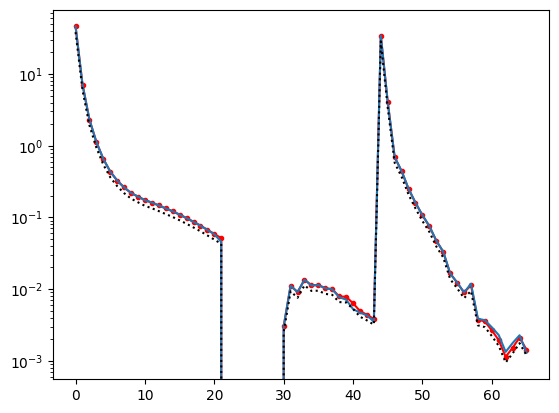

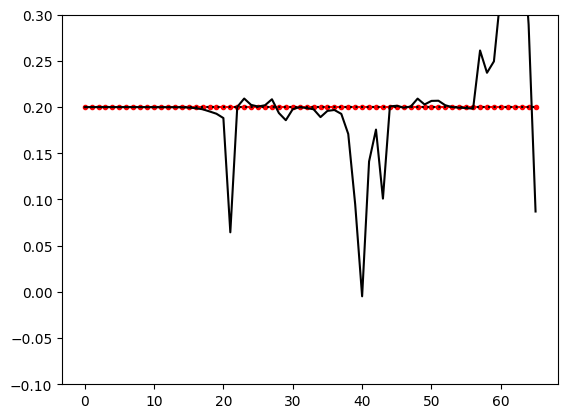

step: 4 0.6649999999999999
[[-2.3439567e-13  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.3090375e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -8.4721218e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.5245077e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -4.7491678e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.2353871e-08]]
[1.9992903e-01 1.9998752e-01 1.9998956e-01 1.9998817e-01 1.9998203e-01
 1.9998173e-01 1.9998097e-01 1.9997655e-01 1.9996284e-01 1.9993724e-01
 1.9988169e-01 1.9986764e-01 1.9988008e-01 1.9986892e-01 1.9978073e-01
 1.9949822e-01 1.9877163e-01 1.9763002e-01 1.9522241e-01 1.9219562e-01
 1.8821225e-01 6.4791918e-02 2.0016456e-01 2.0924024e-01 2.0235346e-01
 2.0058432e-01 2.0

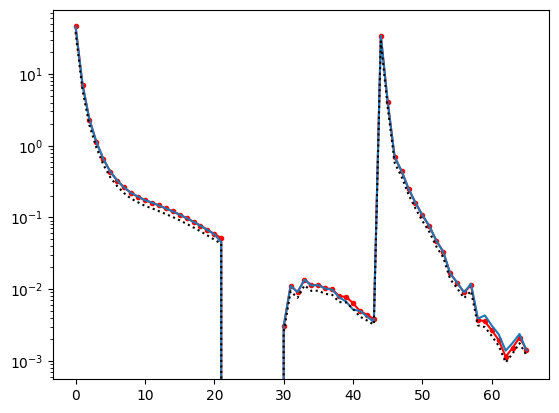

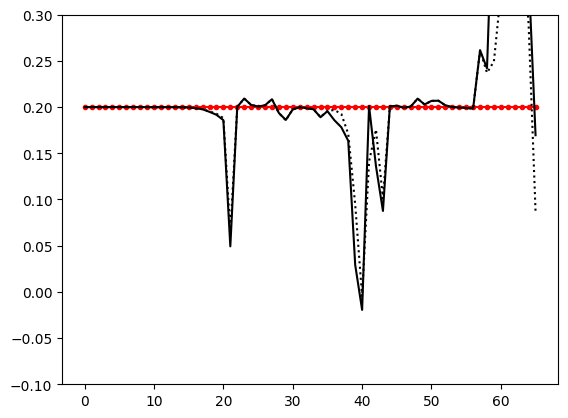

step: 7 0.6317499999999999
[[-2.8142499e-14  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.4692010e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.0548128e-13 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.2362860e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.3821951e-07  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.2095132e-06]]
[ 0.19992903  0.19998752  0.19998969  0.19998868  0.19998269  0.19998264
  0.1999824   0.19997805  0.1999648   0.19993944  0.19988467  0.19987097
  0.19988313  0.19987428  0.19978927  0.19950959  0.19878428  0.1976327
  0.19447346  0.19080509  0.18575864  0.0506345   0.20016456  0.20924024
  0.20235465  0.2005872   0.20196547  0.20848684  0.19361098  0.18627033
  0.19722

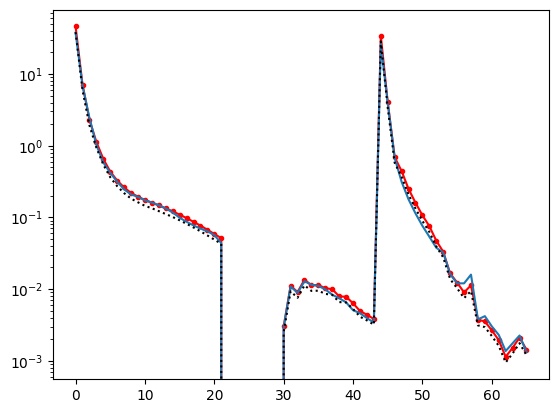

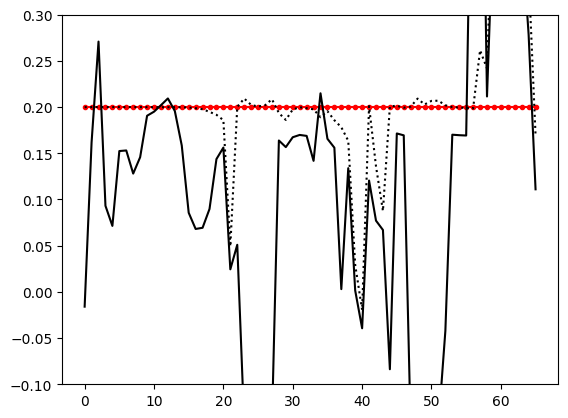

step: 10 0.6001624999999999
[[-3.3845849e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.1801233e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -7.6701626e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.3223813e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.1277210e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -4.1227226e-04]]
[-0.02248861  0.21879311  0.2624618   0.05266084 -0.0124409   0.11494234
  0.11915223  0.0830657   0.05295571  0.07930814  0.13149318  0.1273127
  0.02789425  0.14566562  0.03698517  0.0410114   0.02485009  0.04532123
  0.04848408  0.05379687  0.06878171 -0.12927851  0.0308462  -0.01391483
 -0.14966662 -0.07758492 -0.05904229 -0.01452919  0.2461821   0.33022872
  0.0030

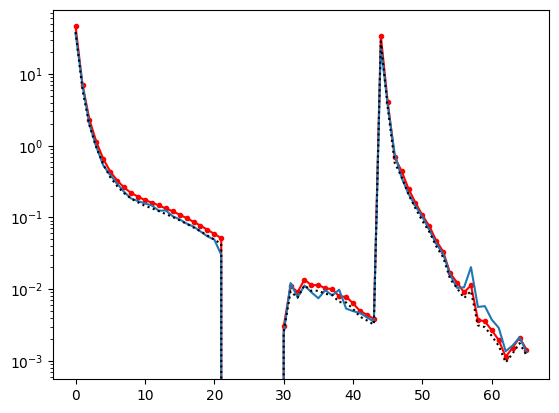

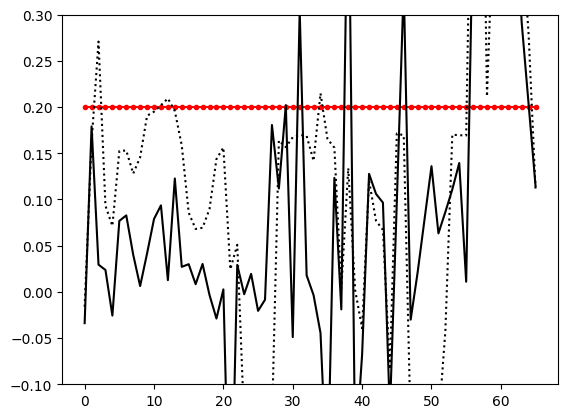

step: 13 0.5701543749999999
[[-6.5607228e-03  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.9363798e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.8995753e-05 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0684970e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.3574019e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.6894777e-04]]
[-0.17157961  0.01102665  0.1761982   0.16960922  0.11323079  0.23031142
  0.23712972  0.18849967  0.1497608   0.1900704   0.23268229  0.20566745
  0.15229085  0.16246027  0.12144025  0.06912471  0.05328503  0.06657254
  0.09572361  0.10955997  0.11130063 -0.19804052  0.17588791 -0.14471447
 -0.12584132 -0.1601318  -0.14984769  0.01235692  0.27037385  0.3734256
 -0.1845

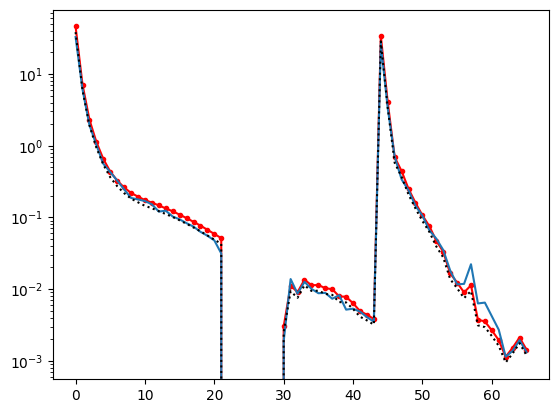

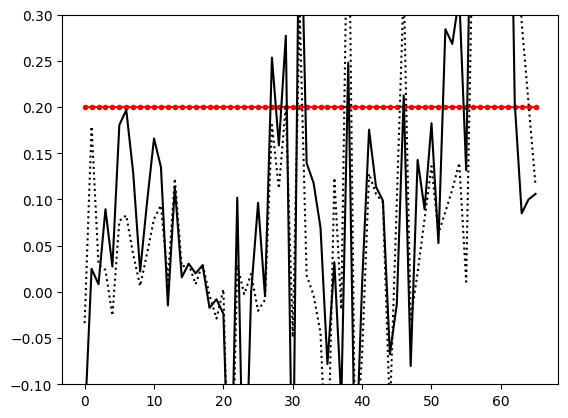

step: 16 0.5416466562499999
[[-4.3505119e-04  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -6.5692911e-05  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -4.3531738e-05 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.2894003e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.4027782e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.4873411e-04]]
[-0.14453791  0.0249916   0.00709325  0.08405608  0.01947954  0.16413133
  0.17538832  0.12367273  0.02149189  0.09593279  0.16219874  0.13327126
 -0.01486742  0.11270558  0.0154035   0.0303043   0.01941088  0.02785116
 -0.01572913 -0.00920955 -0.02601785 -0.26544532  0.10231563 -0.26853272
  0.00555681  0.11307789  0.00753981  0.2987846   0.16307913  0.2659915
 -0.2222

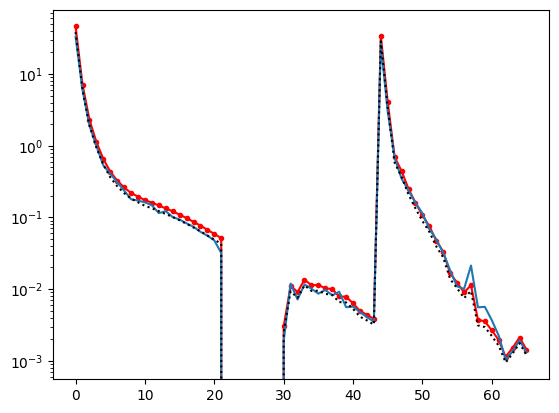

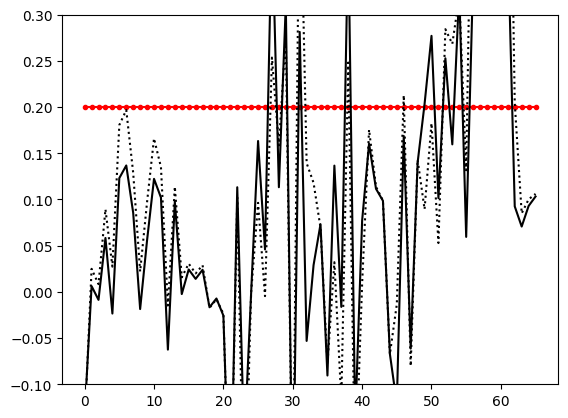

step: 19 0.5145643234374998
[[-2.7630880e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.9380703e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -4.2975924e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0307476e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.3025499e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.9372479e-04]]
[-0.13266301  0.00333025 -0.00763162  0.05781995 -0.02545923  0.10433874
  0.11972619  0.07040843 -0.02425887  0.0370649   0.1018312   0.09232645
 -0.05939519  0.0917495  -0.00952747  0.02236296  0.00959653  0.01944714
 -0.01918659 -0.01272015 -0.03064269 -0.2642869   0.10996404 -0.17478502
 -0.00234822  0.1484136   0.04461722  0.4256332   0.0661146   0.2529101
 -0.1883

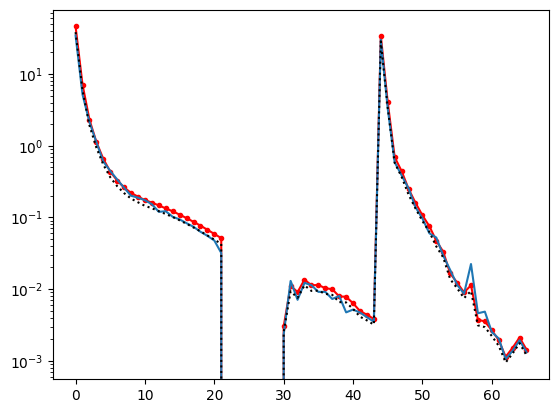

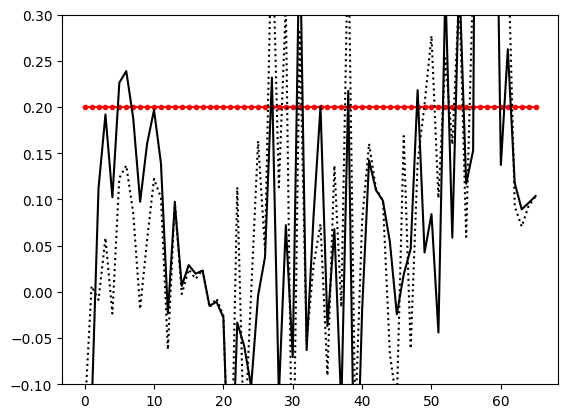

step: 22 0.48883610726562476
[[-3.1412003e-04  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.4895529e-04  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.1770294e-05 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0796699e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.4943443e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.0013599e-04]]
[-0.10181183 -0.12903541  0.10965084  0.18911645  0.09923375  0.2201657
  0.2351699   0.18418255  0.09461508  0.15695599  0.18885212  0.12794062
 -0.02769661  0.07193017 -0.00268982  0.0189511   0.00830602  0.01556196
 -0.02632963 -0.0216127  -0.03586617 -0.26643774 -0.03342018 -0.06028062
 -0.03440862  0.02611705  0.07514083  0.35134536 -0.07296429  0.20330194
 -0.106

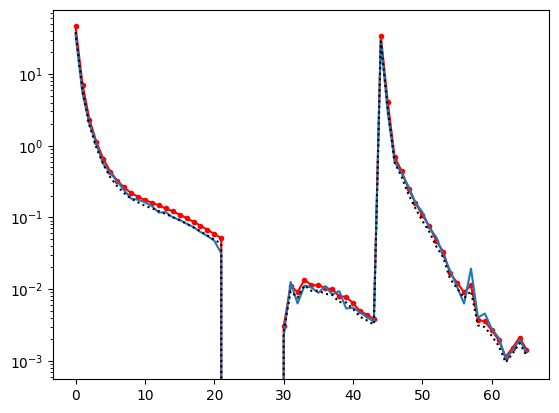

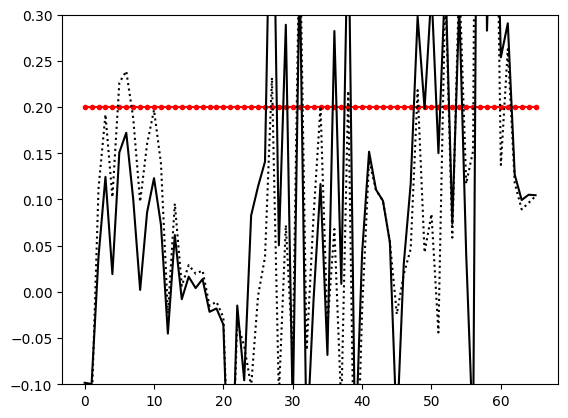

step: 25 0.4643943019023435
[[-6.3401282e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.4014775e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -5.3137349e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0728462e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.5792349e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.9515583e-04]]
[-1.10168941e-01 -1.46685541e-01  4.96356636e-02  1.09545805e-01
  1.09851416e-02  1.42827645e-01  1.57339215e-01  9.56988856e-02
  3.82606350e-02  1.03953458e-01  1.27329737e-01  8.79748836e-02
  6.57202005e-02  6.55122101e-02  2.34408546e-02  3.08551732e-02
  2.27888860e-02  2.51626838e-02 -3.57399741e-03  2.51118588e-04
 -2.19967421e-02 -2.39070490e-01 -1.46890916e-0

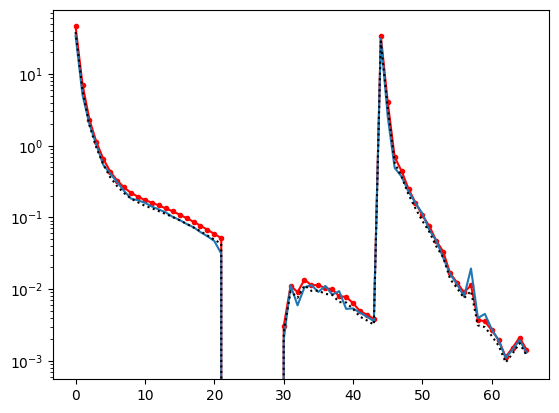

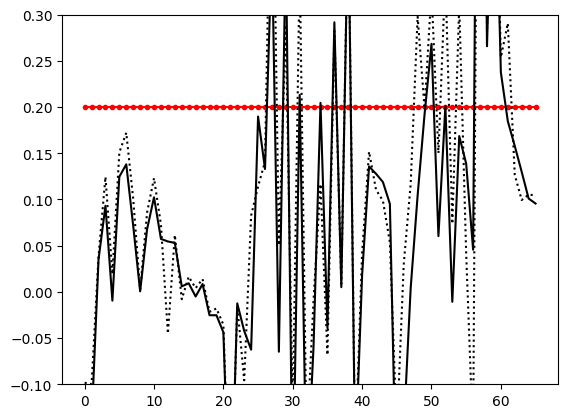

step: 28 0.44117458680722627
[[-4.5610660e-16  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.9943215e-15  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.8107648e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.4309787e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.1125634e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.1237145e-07]]
[-1.10207900e-01 -1.42784730e-01  3.49393189e-02  9.31833461e-02
 -9.47344489e-03  1.24608248e-01  1.38018295e-01  7.16065615e-02
  5.78035368e-04  6.77823797e-02  1.02358013e-01  5.72981387e-02
  5.45414127e-02  5.30265048e-02  5.94568811e-03  9.31169745e-03
 -5.01438882e-03  8.48258659e-03 -2.51846369e-02 -2.51429994e-02
 -4.35791947e-02 -2.68659085e-01 -1.24637634e-

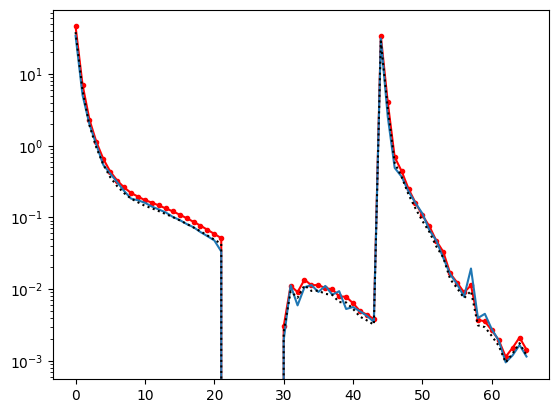

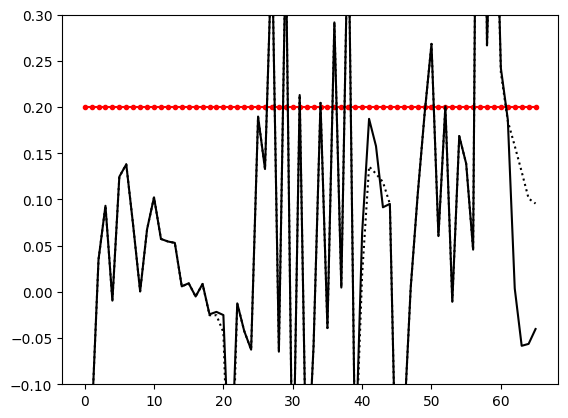

step: 31 0.4191158574668649
[[-6.5896516e-16  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.7327475e-15  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -5.4084399e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.4727631e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.8778464e-09  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -5.3416468e-08]]
[-1.10207900e-01 -1.42784730e-01  3.49393785e-02  9.31834728e-02
 -9.47322603e-03  1.24608740e-01  1.38018832e-01  7.16071054e-02
  5.78688516e-04  6.77833930e-02  1.02358736e-01  5.72986938e-02
  5.45426309e-02  5.30275069e-02  5.94392093e-03  9.30924155e-03
 -4.98590199e-03  8.64981767e-03 -2.42588017e-02 -2.14575976e-02
 -2.50330083e-02 -2.17377618e-01 -1.24637634e-0

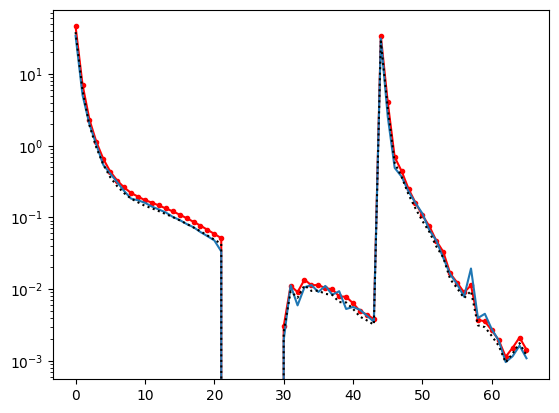

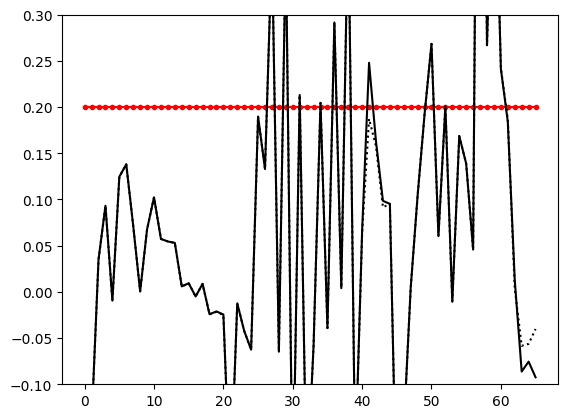

step: 34 0.39816006459352166
[[-1.21641984e-04  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -4.81888528e-05  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -3.54812248e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -8.71095017e-06
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -1.96646070e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -1.61503966e-04]]
[-0.11017172 -0.14247532  0.02856341  0.0918952  -0.00988853  0.11917356
  0.13371676  0.06724222 -0.00818892  0.05936335  0.09700015  0.05476969
  0.05420857  0.05245983  0.00501197  0.00872431 -0.00563093  0.00730774
 -0.03223536 -0.02740686 -0.03304759 -0.230815   -0.01238952 -0.04332935
 -0.06328443  0.1868308   0.12361066  0.374

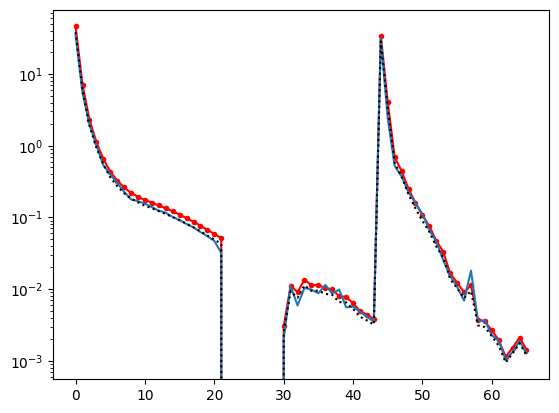

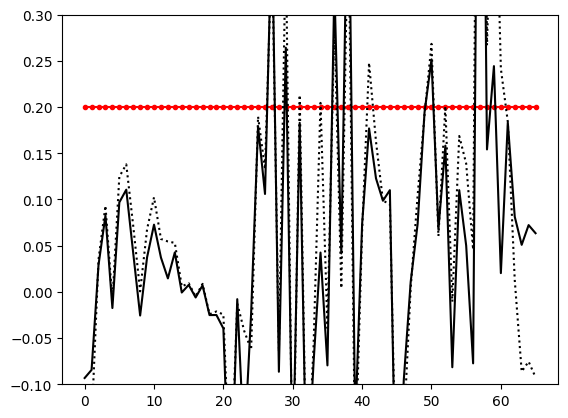

step: 37 0.37825206136384554
[[-1.20303154e-01  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -4.73567145e-03  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.29622135e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -8.50432207e-06
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -2.06637396e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -2.22264134e-04]]
[-9.66534317e-02 -1.01660043e-01  1.10881673e-02  7.72683024e-02
 -2.30367891e-02  8.38360935e-02  9.85336453e-02  3.26850601e-02
 -2.27296893e-02  3.15953158e-02  6.60554022e-02  3.48561183e-02
  1.92314386e-02  4.18395288e-02  3.72604227e-05  7.48346327e-03
 -6.04888564e-03  7.10453000e-03 -2.43203305e-02 -2.50430573e-02
 -4.171485

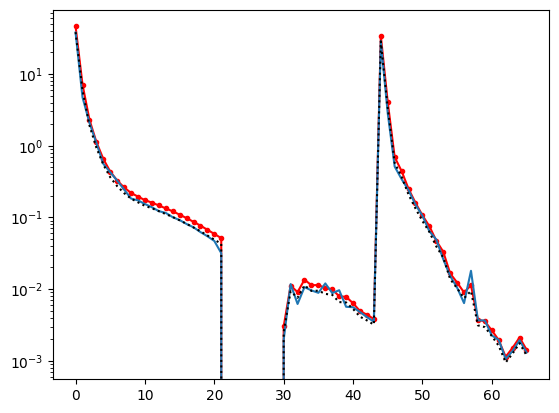

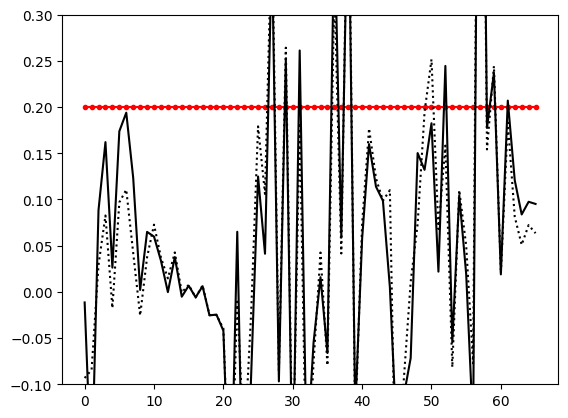

step: 40 0.3593394582956532
[[-6.5325864e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.6348839e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -6.5573939e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.4206549e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.1011540e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.2794495e-04]]
[-0.03064354 -0.13330501  0.18639916  0.05766611  0.02044665  0.21781942
  0.21676452  0.181193    0.09213851  0.14176674  0.14140311  0.0903931
  0.07228875  0.04886808  0.04286134  0.0338315   0.02048082  0.02848245
  0.00515452 -0.00447322 -0.02638442 -0.23504055 -0.03062728 -0.3670906
 -0.00921777  0.22591661 -0.01349295  0.25094453 -0.17800967  0.13885866
 -0.15002

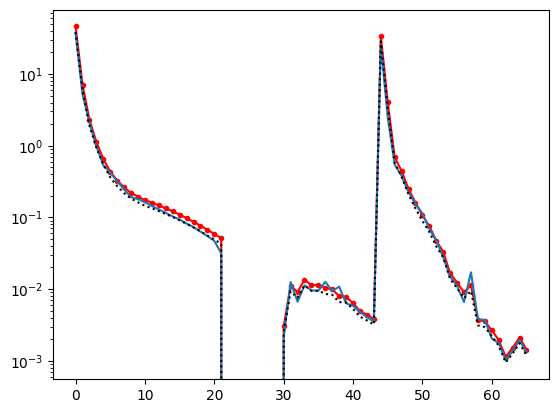

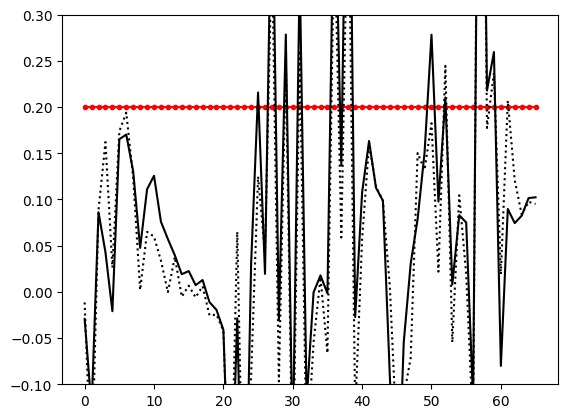

step: 43 0.34137248538087056
[[-6.7594503e-03  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.7091583e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.5740807e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.9161094e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.1619806e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.3283994e-04]]
[-0.02957309 -0.1268818   0.07466587  0.04194848 -0.02624364  0.15296318
  0.15322635  0.08895643  0.03561653  0.10247102  0.11564233  0.06709236
  0.041689    0.03702719  0.01973168  0.0218797   0.00590398  0.01197093
 -0.0126682  -0.02026029 -0.04273433 -0.26571742 -0.02869385 -0.30245352
  0.08827108  0.19960088  0.02902164  0.5454775   0.00930187  0.3059375
 -0.144

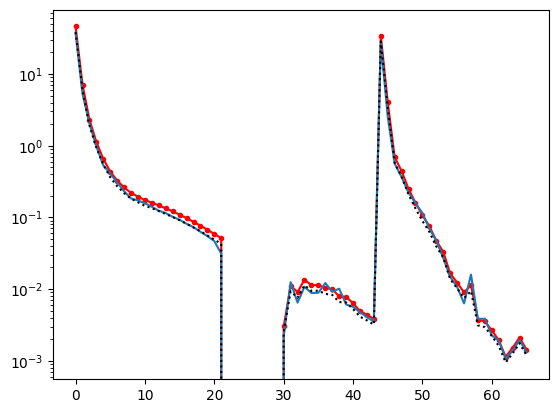

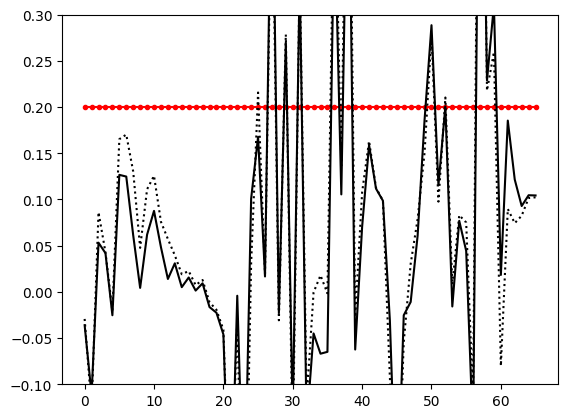

step: 46 0.324303861111827
[[-3.2633889e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.2762464e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -5.4203678e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.1663824e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.2489119e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.3379804e-04]]
[-0.03720378 -0.10543488  0.03864368  0.04166812 -0.02676502  0.11555242
  0.11275341  0.04975709 -0.00231386  0.05326877  0.07726453  0.04100778
  0.0091152   0.02860281  0.00280727  0.01477151  0.0011195   0.00912295
 -0.01623137 -0.02221009 -0.04632113 -0.27286705 -0.00410183 -0.24626817
  0.11498971  0.15602474  0.01435227  0.49995476 -0.03839764  0.25061384
 -0.1316

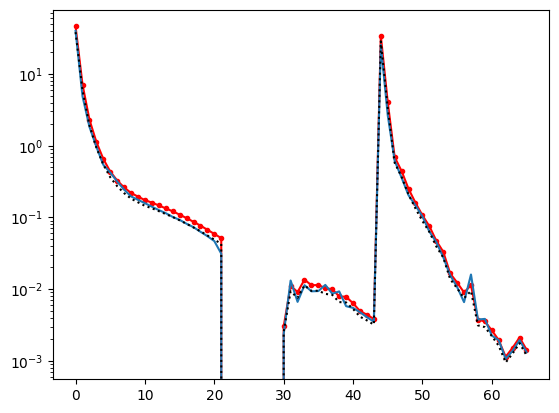

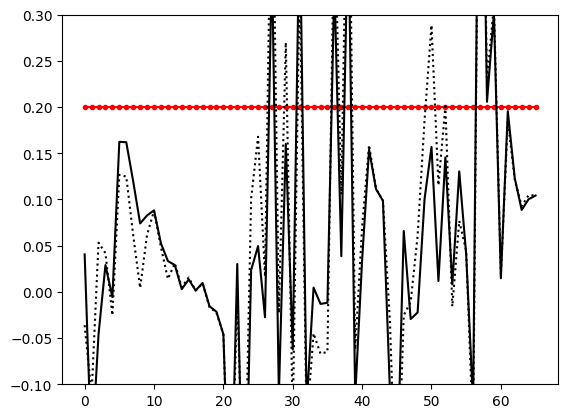

step: 49 0.30808866805623564
[[-1.3557345e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.7077904e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.5782225e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.1588226e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.2801236e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.4148045e-04]]
[ 0.04266763 -0.24179624 -0.11963176  0.01394262 -0.03211945  0.12554464
  0.13724275  0.07460748  0.0099476   0.04355839  0.05449459  0.02301576
 -0.02272518  0.02046856 -0.0050722   0.01090301 -0.001682    0.00635374
 -0.02003879 -0.02328643 -0.04671281 -0.27180186  0.05694849 -0.3622177
  0.00558208 -0.01168107  0.04745231  0.46186143 -0.04279118  0.07083382
  0.009

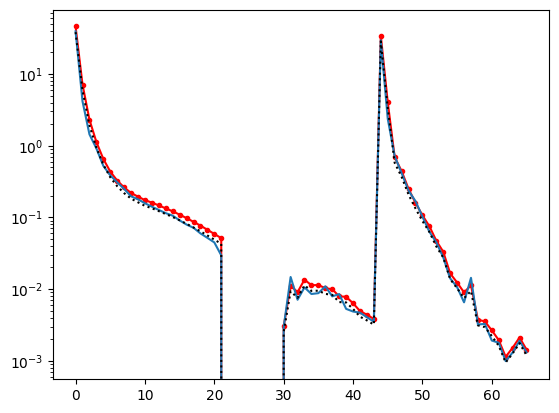

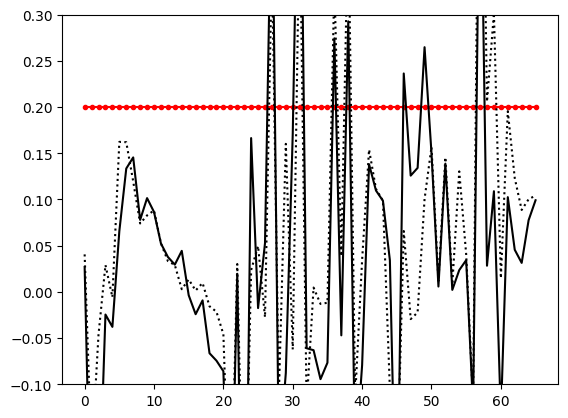

step: 52 0.29268423465342386
[[-1.5496824e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.1523858e-04  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.3671837e-05 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.2043738e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.3173892e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.3898754e-04]]
[ 0.02746142 -0.29969707 -0.24291144 -0.02208117 -0.0348011   0.06197246
  0.1219739   0.13911739  0.07372629  0.08458801  0.07694904  0.04743662
  0.03463642  0.02680817  0.03928184 -0.0027349  -0.01853265 -0.00359423
 -0.04308327 -0.04793438 -0.06485849 -0.280324    0.01931154 -0.4573894
  0.15586343 -0.0194276   0.05450639  0.46790463 -0.16489191 -0.0210206
  0.0857

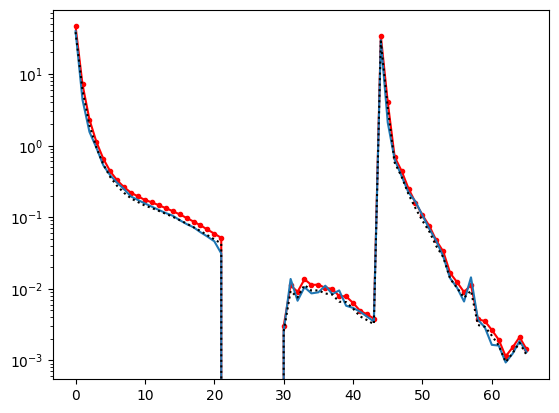

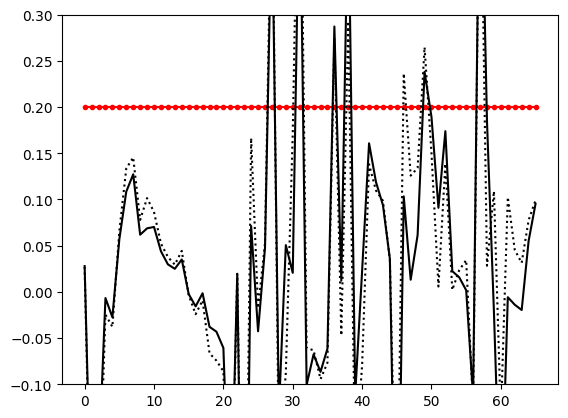

step: 55 0.27805002292075265
[[-1.0321146e-11  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.7017261e-13  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -6.9747878e-15 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.6281450e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.8741835e-07  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -5.5074406e-06]]
[ 0.02793169 -0.2686052  -0.19216798 -0.00664423 -0.02744479  0.05689524
  0.10849188  0.12726156  0.06188105  0.06876954  0.07026616  0.04395146
  0.02980123  0.024952    0.03506972 -0.00241186 -0.015687   -0.0015026
 -0.03782408 -0.04300402 -0.06038344 -0.27101296  0.01893415 -0.49535316
  0.07128768 -0.04263575  0.04770965  0.4292934  -0.12999885  0.05062777
  0.020

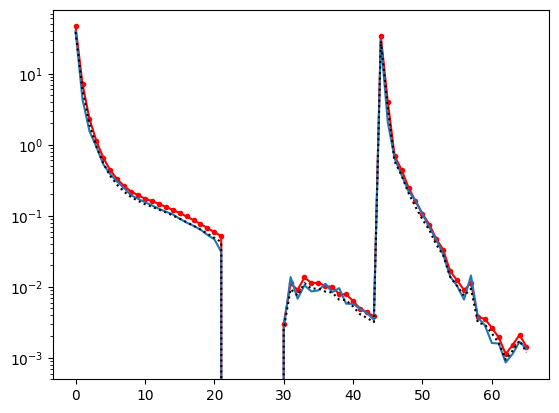

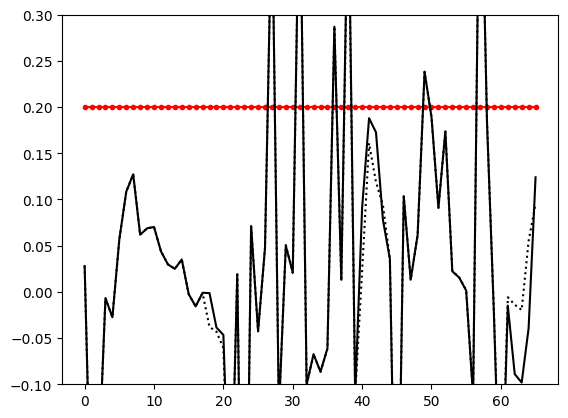

step: 58 0.264147521774715
[[-5.3597568e-15  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.3504947e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.2733121e-13 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.4157193e-10
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.3175250e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -4.4359320e-05]]
[ 0.02793169 -0.2686053  -0.19216867 -0.00664499 -0.02744589  0.0568936
  0.10848968  0.12725827  0.06187811  0.06876568  0.07025576  0.04394123
  0.02979477  0.02492689  0.0350611  -0.00244231 -0.01572529 -0.00096142
 -0.00132941 -0.03854052 -0.04646156 -0.27579919  0.01893415 -0.49536535
  0.0712842  -0.04264027  0.04770043  0.42927235 -0.13004255  0.049957
  0.0209825

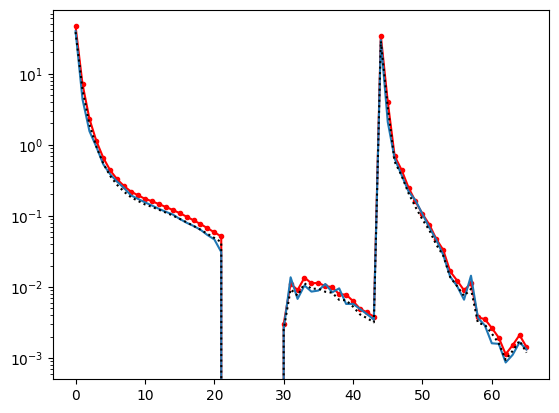

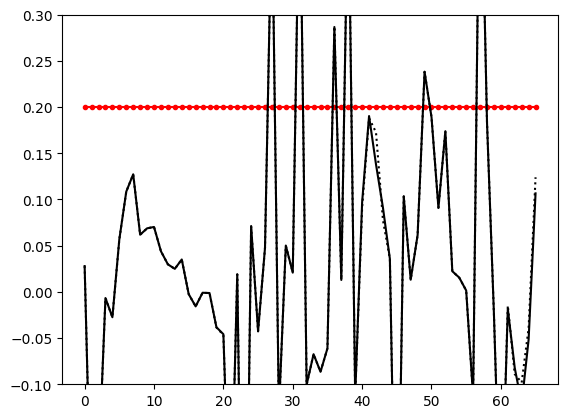

step: 61 0.2509401456859792
[[-2.3544160e-14  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.8714159e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -6.8982802e-13 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.2311230e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.3394477e-06  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -4.4324975e-06]]
[ 0.02793169 -0.2686053  -0.19216867 -0.00664505 -0.027446    0.05689319
  0.10848946  0.12725821  0.06187722  0.06876532  0.07025649  0.04394178
  0.0297955   0.02492703  0.03506242 -0.00244141 -0.01571118 -0.00092905
 -0.00122079 -0.03709975 -0.03886712 -0.26125458  0.01893415 -0.49537137
  0.07128563 -0.04263949  0.04770174  0.42927226 -0.13003969  0.05001632
  0.021

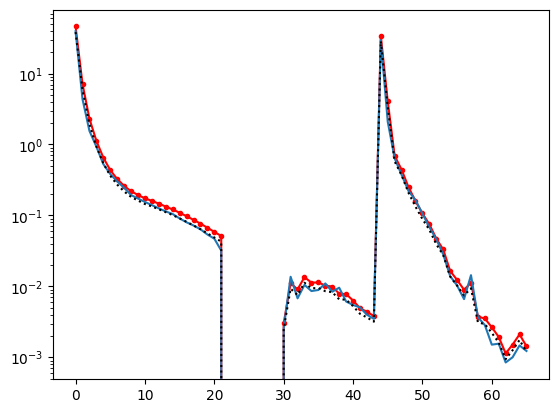

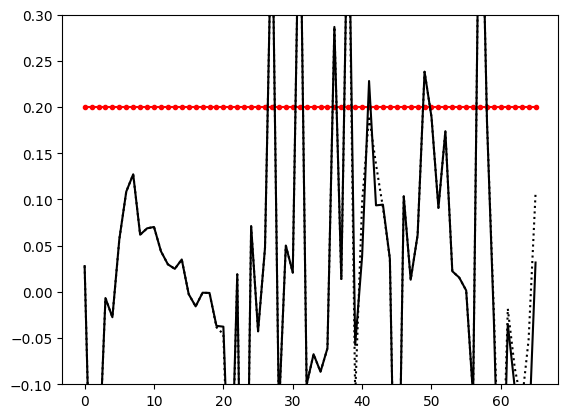

step: 64 0.23839313840168025
[[-8.7963416e-14  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.6522362e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -8.2481678e-13 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.3896966e-07
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.5649916e-07  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -6.9743342e-05]]
[ 0.02793169 -0.2686053  -0.19216861 -0.0066448  -0.02744567  0.05689368
  0.10849012  0.12725903  0.06187803  0.06876642  0.07025772  0.04394311
  0.02979696  0.02493017  0.03506758 -0.00242962 -0.01569506 -0.00089771
 -0.00104907 -0.03634666 -0.03735634 -0.24717216  0.01893415 -0.49537134
  0.07128666 -0.04263778  0.04770494  0.4292788  -0.13002296  0.05021993
  0.02

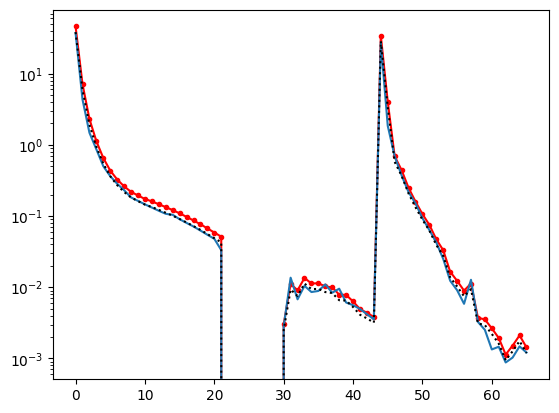

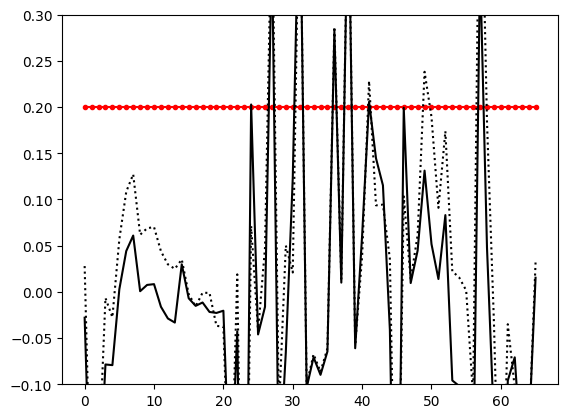

step: 67 0.22647348148159624
[[-7.3102340e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.9249258e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -6.9342868e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1786401e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.3990058e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.4247289e-04]]
[-2.5328383e-02 -2.4684025e-01 -1.8606377e-01 -6.5956973e-02
 -5.9376292e-02  4.0171528e-03  4.1279465e-02  5.5439897e-02
 -1.4717042e-03  6.2544411e-03  7.2003435e-03 -1.5059454e-02
 -2.3276446e-02 -3.1649709e-02  2.9047664e-02 -6.0001309e-03
 -1.0438125e-02 -8.6379610e-03 -2.1265628e-02 -2.3086809e-02
 -2.2701863e-02 -2.2550365e-01 -4.6802253e-02 -5.7899606e-01
  1.4

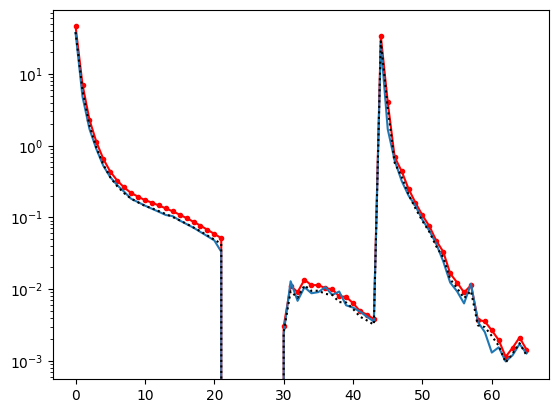

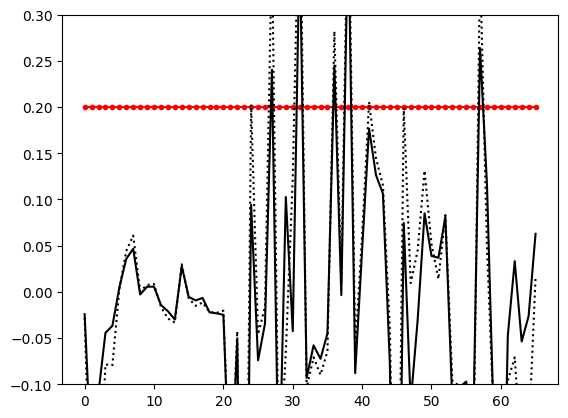

step: 70 0.2151498074075164
[[-1.5683596e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.9137454e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -6.5005972e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1590775e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.3227487e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.4485559e-04]]
[-0.02365139 -0.17347601 -0.06083137 -0.0331416  -0.02471378  0.00485469
  0.03320852  0.04246784 -0.00386435  0.00496245  0.00485758 -0.01345424
 -0.01856946 -0.02884239  0.02684179 -0.00545245 -0.00905941 -0.00593763
 -0.02301962 -0.02361673 -0.02588267 -0.22528324 -0.05074063 -0.55089474
  0.06074008 -0.08238222 -0.03980937  0.19621196 -0.23817283  0.14745057
 -0.080

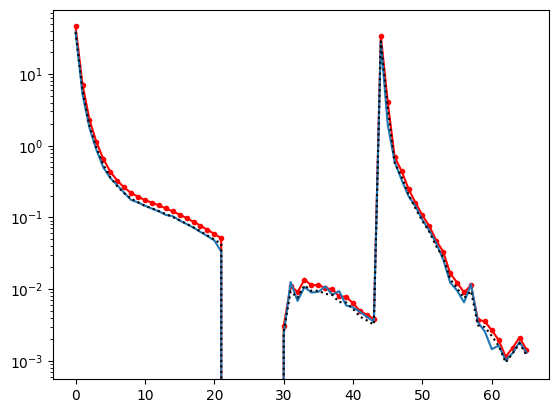

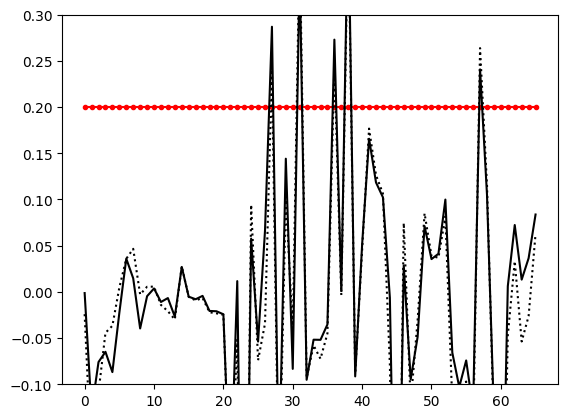

step: 73 0.2043923170371406
[[-1.0143331e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.9257121e-04  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -9.1259157e-05 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1873771e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.3010696e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.5205855e-04]]
[ 0.00432482 -0.1253827  -0.12316291 -0.01709673 -0.04017074 -0.00238556
  0.05103469  0.0665378   0.00945994  0.0336718   0.00889824 -0.01692373
 -0.0536979  -0.03107674  0.02339844 -0.0062504  -0.01202367 -0.00739476
 -0.0307698  -0.0284999  -0.03214245 -0.22871879 -0.0343908  -0.5017348
  0.11171626 -0.10214452  0.05765578  0.22118403 -0.2460825   0.085668
 -0.036492

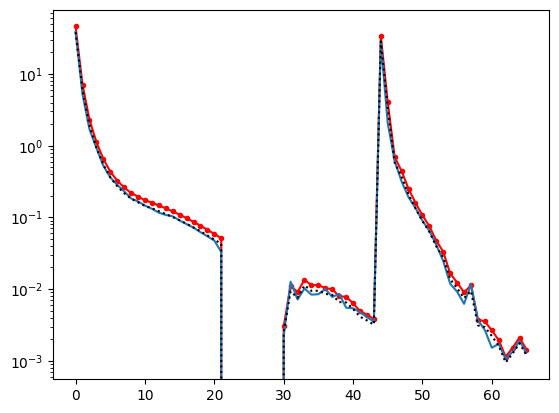

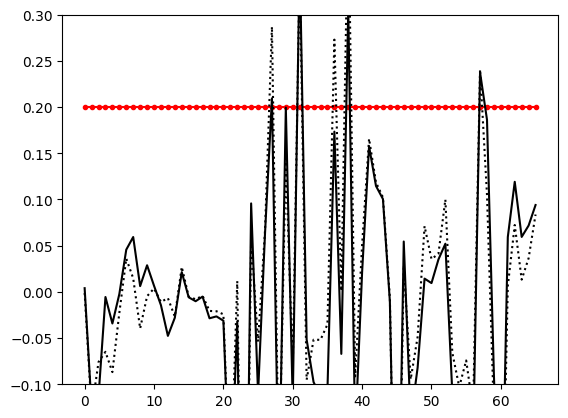

step: 76 0.19417270118528354
[[-9.9668622e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.0928239e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -6.6976249e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1347483e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.3062308e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.5162561e-04]]
[ 0.00397553 -0.12009733 -0.08413876 -0.00058614 -0.02804268 -0.00237192
  0.04290568  0.05427235  0.00311315  0.02578976  0.00559078 -0.01341531
 -0.04304788 -0.02659986  0.02280684 -0.00405606 -0.00745444 -0.00309078
 -0.02506146 -0.02385713 -0.02880439 -0.22385453 -0.03474842 -0.510347
  0.10084905 -0.11193119  0.06137202  0.19440743 -0.22509043  0.23733015
 -0.1625

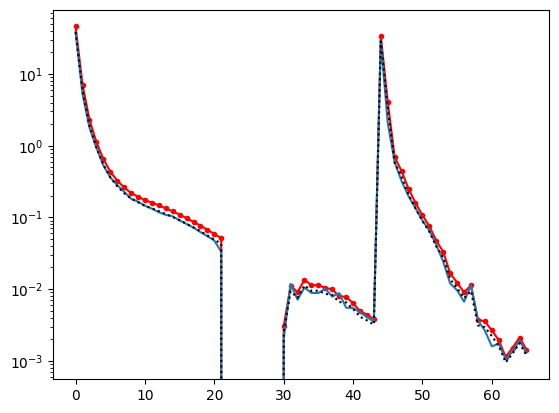

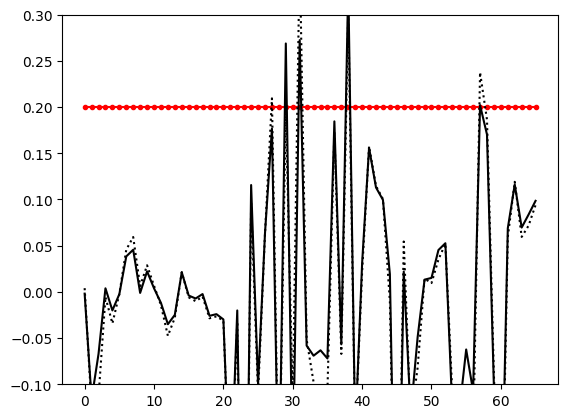

step: 79 0.18446406612601934
[[-1.6476889e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.2655962e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -9.1543561e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1464176e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.3151391e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.5413715e-04]]
[-0.00680815 -0.11089896 -0.04598724  0.00693825 -0.01620646 -0.00247546
  0.03657807  0.04295046 -0.00230765  0.02070604  0.00315783 -0.01134559
 -0.03192676 -0.02405723  0.02125081 -0.00327489 -0.00607435 -0.00148435
 -0.02495284 -0.02336115 -0.02945828 -0.22370765 -0.01593792 -0.47996238
  0.10566114 -0.09951791  0.06836992  0.16859539 -0.2625172   0.22735289
 -0.20

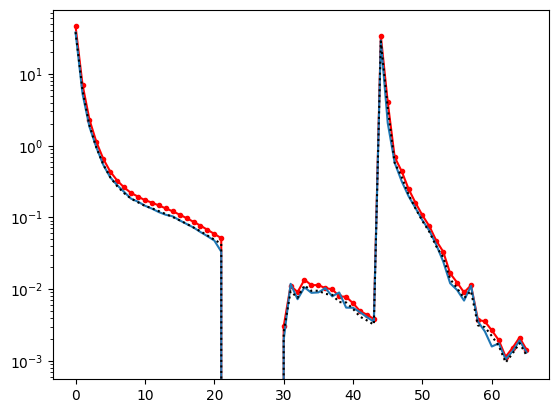

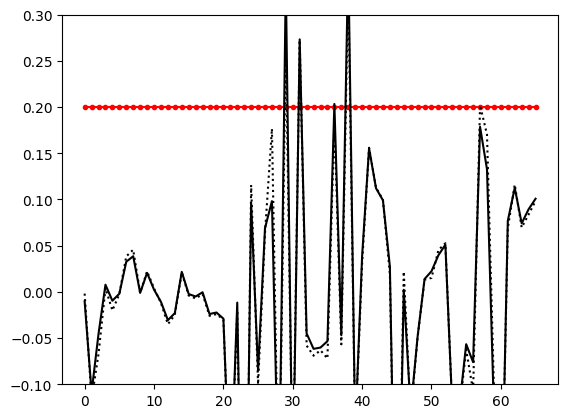

step: 82 0.17524086281971837
[[-2.0930065e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.9588735e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -6.7702064e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1577597e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.3223161e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.5637556e-04]]
[-0.01655508 -0.10098907 -0.03305042  0.00897279 -0.00833721 -0.00111997
  0.03079154  0.03676697 -0.0015144   0.01984998  0.00201421 -0.01098464
 -0.0328266  -0.02333354  0.01791615 -0.00436412 -0.00763929 -0.00179438
 -0.02776138 -0.02503055 -0.03197309 -0.22569247 -0.00778412 -0.44028834
  0.09386109 -0.09446875  0.06029351  0.05006239 -0.2038898   0.393731
 -0.2329

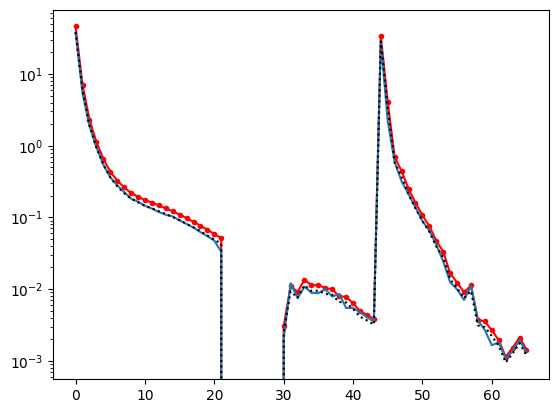

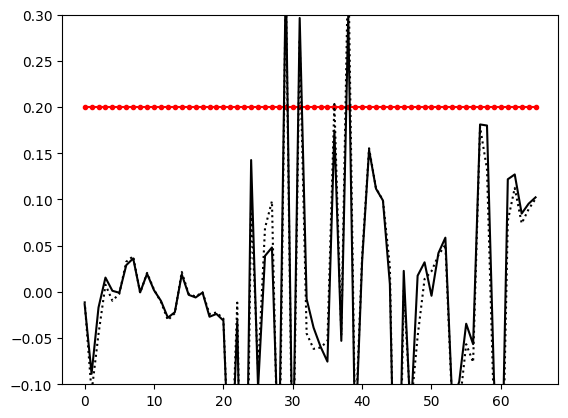

step: 85 0.16647881967873246
[[-1.1867475e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.7938251e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -7.4215524e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1615272e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.3166081e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.5525337e-04]]
[-0.01553135 -0.08836158 -0.00284147  0.01897     0.00067266 -0.00084633
  0.02803155  0.03470282 -0.00130727  0.01888891  0.0013317  -0.0094752
 -0.02702811 -0.02134653  0.02172017 -0.0012803  -0.00370565  0.00087389
 -0.02353449 -0.02152108 -0.02903151 -0.22242086 -0.02040589 -0.3923344
  0.1481051  -0.10608606  0.04822392  0.03705494 -0.20334312  0.33636004
 -0.2099

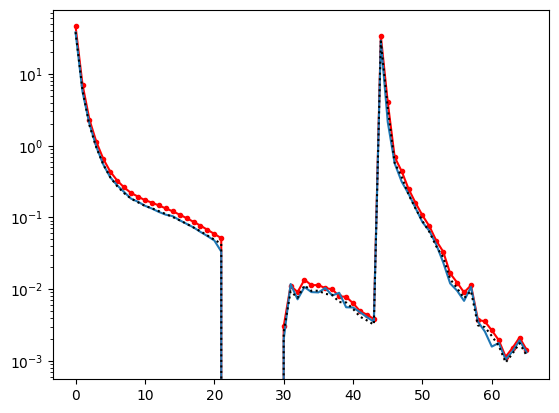

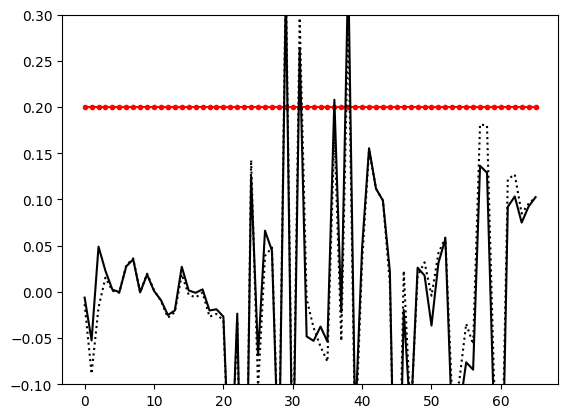

step: 88 0.15815487869479583
[[-4.6119300e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.9691152e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -5.6389655e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1568206e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.3114356e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.5768412e-04]]
[ 2.87665520e-04 -5.07899150e-02  4.99472357e-02  2.25610454e-02
  2.34975223e-03 -1.70760846e-04  2.66041756e-02  3.39140370e-02
 -1.24351087e-03  1.78537928e-02  5.17461391e-04 -9.02548339e-03
 -2.62301322e-02 -2.07376033e-02  1.74464192e-02 -3.21488222e-03
 -5.67507790e-03  3.01056880e-05 -2.72572748e-02 -2.38154121e-02
 -3.18490267e-02 -2.25477189e-01 -3.33056897e-

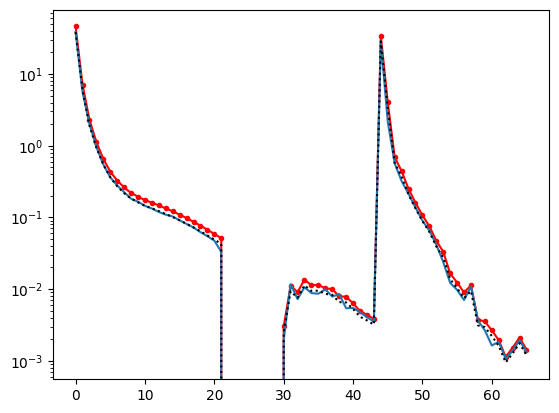

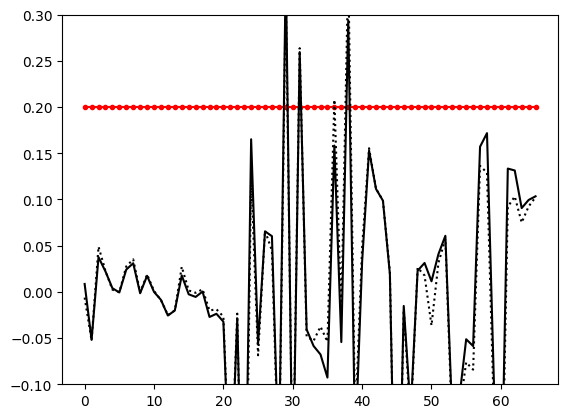

step: 91 0.15024713476005602
[[-4.1548662e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.1042470e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -5.4827431e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1693928e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.3248216e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.5550398e-04]]
[ 7.93435983e-03 -5.51327467e-02  3.55506130e-02  2.16822121e-02
  4.39760322e-03 -6.14673307e-04  2.36306638e-02  3.04112788e-02
 -1.43186224e-03  1.70609411e-02 -2.15643187e-04 -8.13261233e-03
 -2.27117036e-02 -1.92034394e-02  2.18214262e-02  3.83952065e-05
 -2.42567295e-03  2.32875743e-03 -2.26390418e-02 -2.04185899e-02
 -2.91214772e-02 -2.22017542e-01 -2.76464559e-

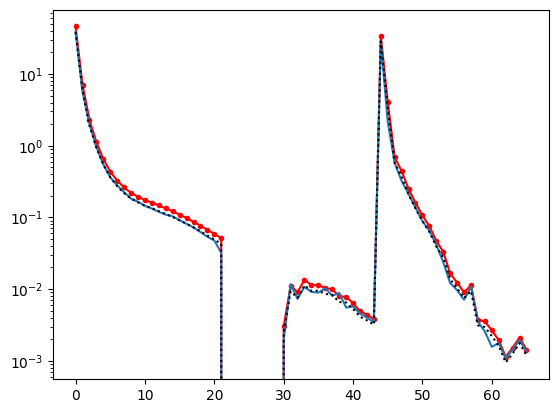

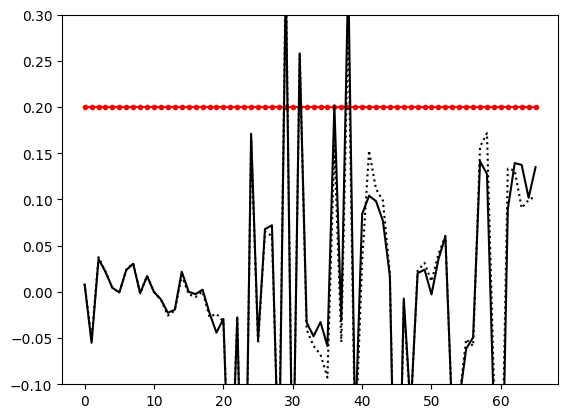

step: 94 0.14273477802205323
[[-5.1472966e-14  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.3191664e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.7599736e-13 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5347065e-09
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.1836308e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.6463712e-06]]
[ 7.93435983e-03 -5.51327467e-02  3.55506130e-02  2.16820855e-02
  4.39738436e-03 -6.14837627e-04  2.36303359e-02  3.04109361e-02
 -1.43210718e-03  1.70605723e-02 -2.16465851e-04 -8.13305750e-03
 -2.27117036e-02 -1.92034394e-02  2.18159035e-02  3.70034832e-05
 -2.43263436e-03  2.38639116e-03 -2.27972567e-02 -4.41103056e-02
 -2.90106554e-02 -2.48852953e-01 -2.76464559e-

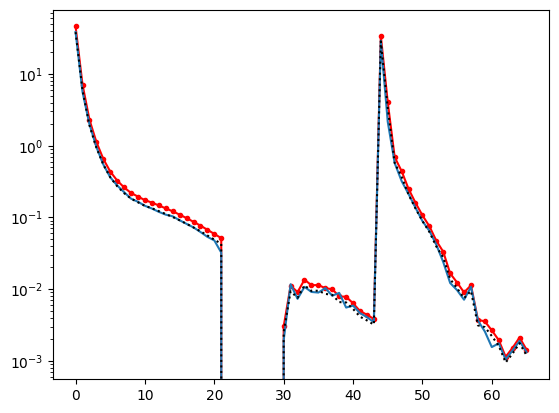

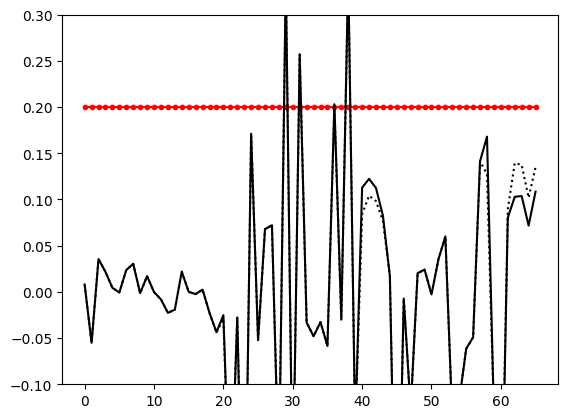

step: 97 0.13559803912095056
[[-3.5779357e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.3422573e-04  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.8438651e-06 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.7494655e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.3473520e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.5250062e-04]]
[ 7.6927170e-03 -5.4257996e-02  3.5595886e-02  2.2160692e-02
  4.5342143e-03 -5.6487491e-04  2.3466881e-02  3.0281080e-02
 -1.4574982e-03  1.7043393e-02 -2.2294441e-04 -8.0620907e-03
 -2.2621056e-02 -1.9053049e-02  2.1832030e-02  1.7134578e-04
 -2.0192568e-03  3.0190230e-03 -2.1242576e-02 -4.1331500e-02
 -2.3272946e-02 -2.3989280e-01 -2.5339359e-02 -3.4629685e-01
  1.7

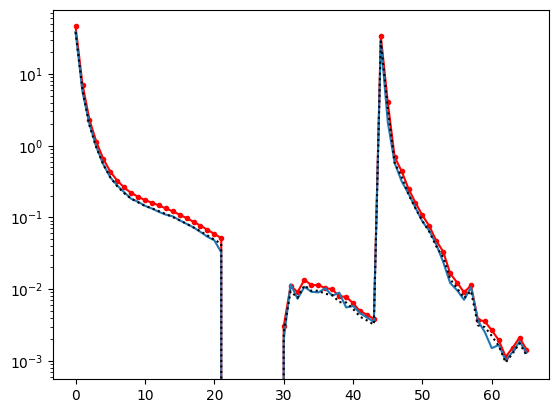

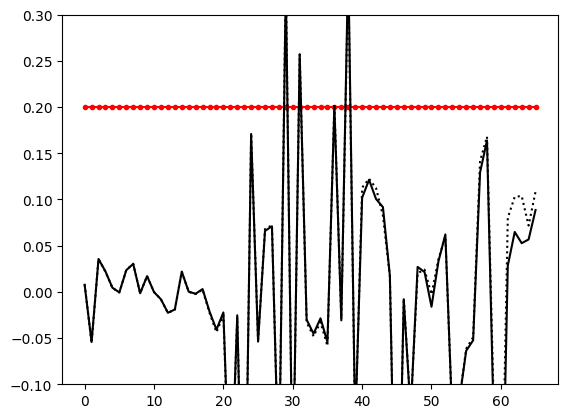

step: 100 0.12881813716490303
[[-1.0570235e-14  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.2210610e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.4838303e-13 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.4041277e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.3949972e-07  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -6.2341013e-07]]
[ 7.6927170e-03 -5.4257996e-02  3.5595886e-02  2.2160819e-02
  4.5344331e-03 -5.6462840e-04  2.3467209e-02  3.0281492e-02
 -1.4570084e-03  1.7043944e-02 -2.2222457e-04 -8.0613121e-03
 -2.2620142e-02 -1.9051442e-02  2.1835197e-02  1.7994171e-04
 -2.0061585e-03  3.0575830e-03 -2.1160267e-02 -4.0775165e-02
 -2.2049185e-02 -2.3733488e-01 -2.5339359e-02 -3.4629685e-01
  1.

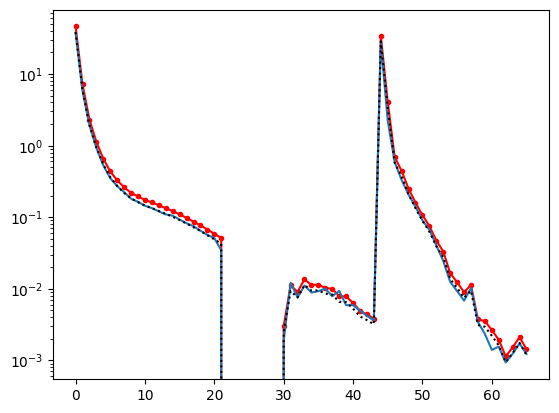

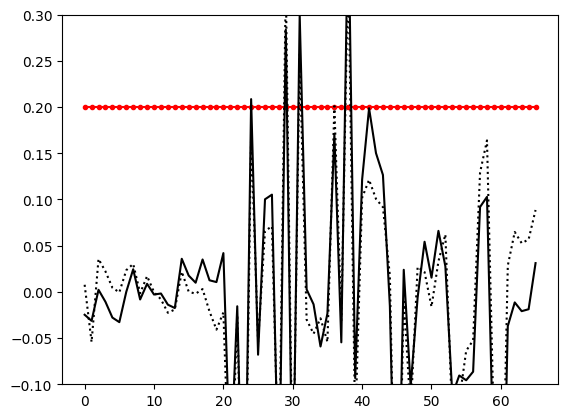

step: 103 0.12237723030665788
[[-2.0634361e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.0741893e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.7423725e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.7463632e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.2543008e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.3836928e-04]]
[-2.17848495e-02 -3.26840691e-02  3.29072885e-02 -4.39543789e-03
 -2.72984393e-02 -3.28456610e-02  3.53420852e-04  2.64340453e-02
 -7.48221064e-03  8.69988184e-03 -3.16667440e-03 -3.86858871e-03
 -3.19149308e-02 -2.01886054e-02  2.61222795e-02 -1.57060137e-03
 -9.53708426e-04  2.71790437e-02 -1.84410308e-02 -2.03154553e-02
  2.28989217e-02 -2.19869390e-01 -2.25040317e

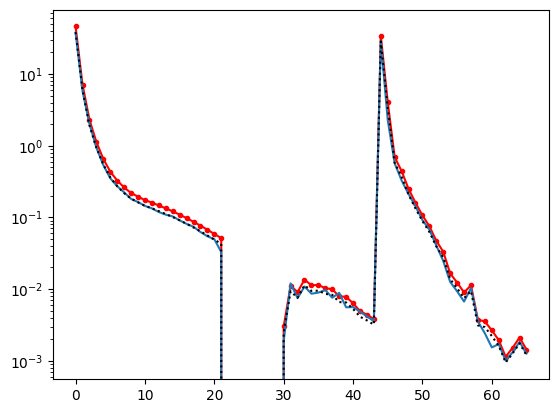

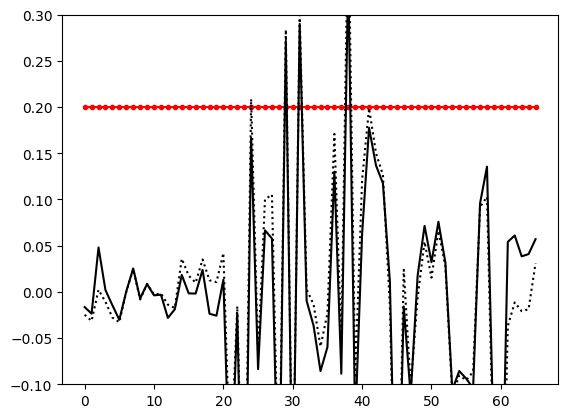

step: 106 0.11625836879132498
[[-1.39643803e-01  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -5.58407418e-03  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -6.38287689e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.32171135e-05
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -3.04891382e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -3.10383068e-04]]
[-1.65949408e-02 -2.63858661e-02  4.63982821e-02 -2.09354956e-04
 -1.03702825e-02 -2.88737025e-02  4.01405443e-04  2.48281546e-02
 -7.20601110e-03  8.24474916e-03 -4.06966079e-03 -3.31130903e-03
 -2.92750746e-02 -1.90764181e-02  5.33935940e-03 -3.92597122e-03
 -2.56224419e-03  2.28426903e-02 -2.52193883e-02 -2.75266971e-02
  9.96280

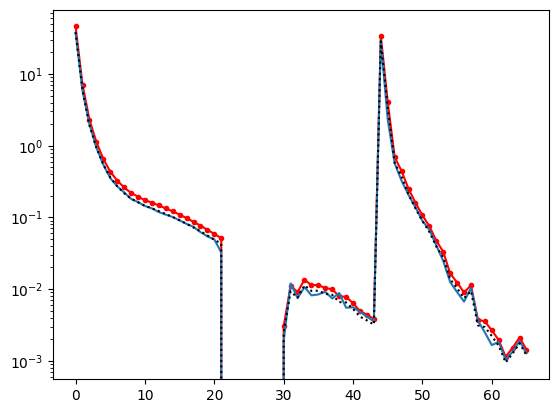

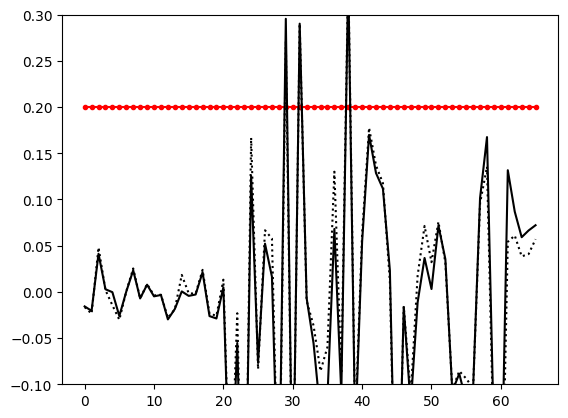

step: 109 0.11044545035175872
[[-2.5268075e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -6.7889271e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -9.9029695e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.2165235e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0495341e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.1513601e-04]]
[-1.14922076e-02 -1.95063632e-02  3.10195070e-02  4.16753581e-03
  1.37486670e-04 -2.54605412e-02  1.42091390e-04  2.28493214e-02
 -6.88156020e-03  7.82746822e-03 -4.88297595e-03 -2.57405359e-03
 -2.35706456e-02 -1.71298515e-02  7.30201183e-03 -1.40940701e-03
 -1.64764759e-03  2.18826085e-02 -2.42289398e-02 -2.67662872e-02
  5.15756663e-03 -2.39582151e-01 -6.17477074e

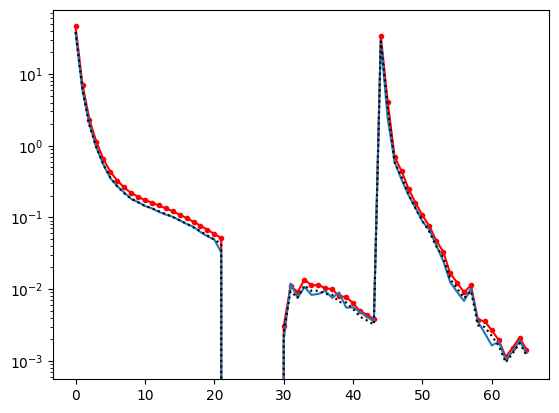

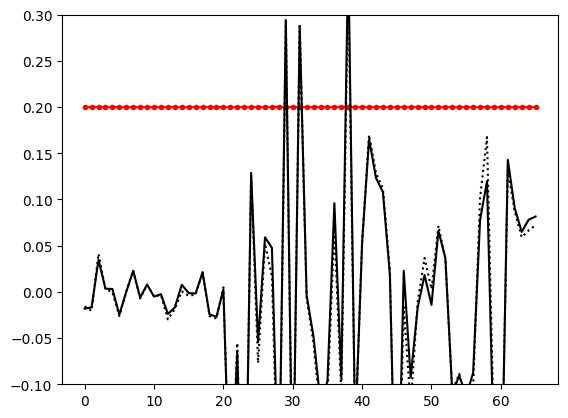

step: 112 0.10492317783417078
[[-3.0629316e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -6.7055300e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -9.3809114e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.2251472e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0201889e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.1591990e-04]]
[-1.07339798e-02 -1.47973942e-02  2.95877326e-02  3.41389584e-03
  3.91629059e-03 -2.45153569e-02 -2.02893803e-04  2.19667386e-02
 -7.42489705e-03  7.47578312e-03 -5.33051044e-03 -2.40064063e-03
 -2.30138265e-02 -1.66591983e-02  6.36917539e-03 -2.04362371e-03
 -2.08007731e-03  2.07301378e-02 -2.47404352e-02 -2.74695400e-02
  1.57784496e-03 -2.41651207e-01 -6.22046851e

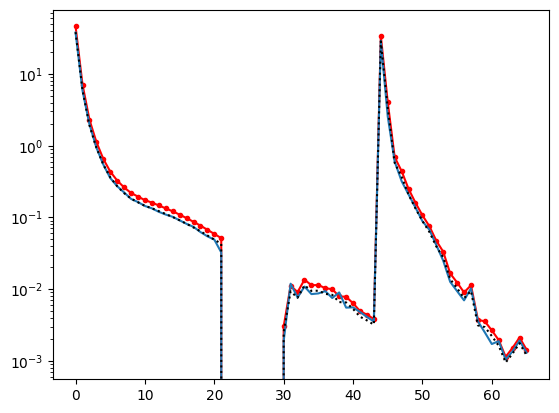

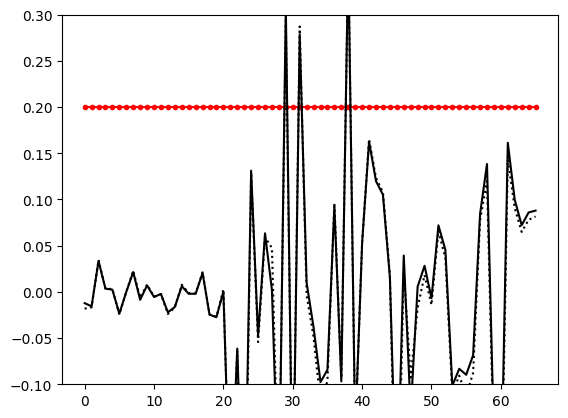

step: 115 0.09967701894246224
[[-1.1884760e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.0890947e-02  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -8.6982653e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.2368780e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0179932e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.1593195e-04]]
[-1.41417328e-02 -1.80261917e-02  2.85198726e-02  4.71925223e-03
  3.46508017e-03 -2.30336487e-02 -2.11877225e-04  2.11473033e-02
 -7.62337213e-03  7.33760837e-03 -5.61690331e-03 -2.23623775e-03
 -2.26340406e-02 -1.61226559e-02  7.93565996e-03 -1.33711926e-03
 -1.75554899e-03  2.03952622e-02 -2.43641045e-02 -2.71498859e-02
 -1.80085917e-04 -2.41551563e-01 -5.27123176e

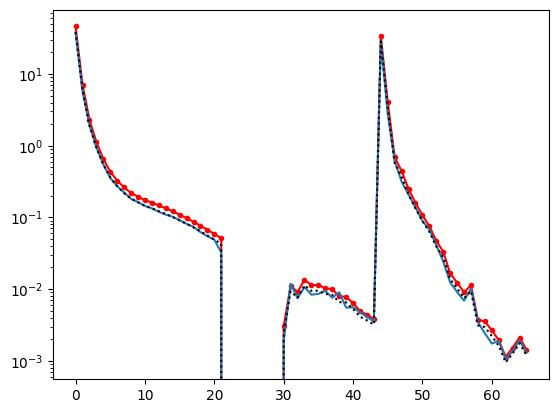

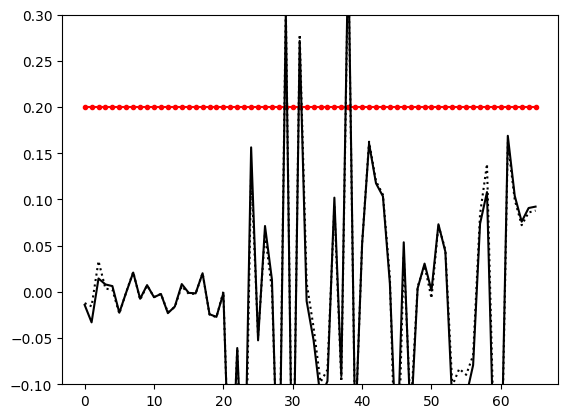

step: 118 0.09469316799533913
[[-3.2948020e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.9396663e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -7.1609888e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.2313652e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0102165e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.1547181e-04]]
[-1.4807817e-02 -3.4172658e-02  1.9190863e-02  7.5847344e-03
  5.7186135e-03 -2.2172531e-02 -2.0585176e-04  2.1074440e-02
 -7.4248156e-03  7.2429804e-03 -5.7823635e-03 -1.8826264e-03
 -2.0667559e-02 -1.5736904e-02  6.1128447e-03 -1.9507876e-03
 -1.8849756e-03  1.9872228e-02 -2.4444958e-02 -2.7319428e-02
 -1.9160198e-03 -2.4178433e-01 -6.0855329e-02 -2.3941895e-01
  1.

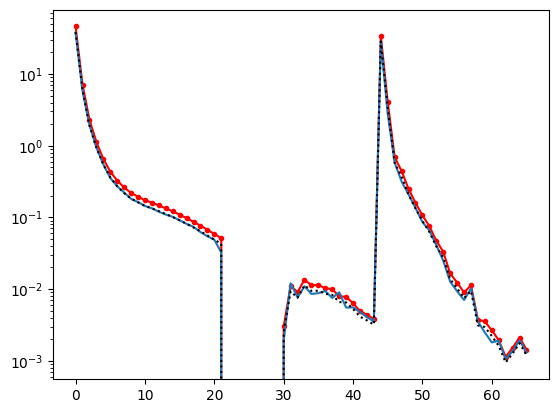

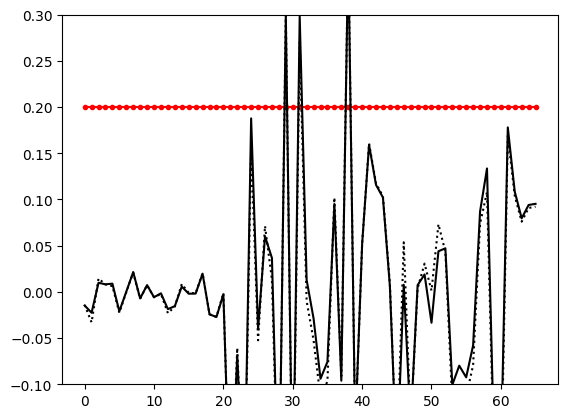

step: 121 0.08995850959557217
[[-1.1684399e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -6.8728328e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -5.2718923e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.2474695e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0045567e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.1593294e-04]]
[-1.31689981e-02 -2.16538180e-02  7.71484524e-03  7.90696032e-03
  1.00978268e-02 -2.02752613e-02  8.38087217e-05  2.09417790e-02
 -7.12885801e-03  7.27384910e-03 -6.00201730e-03 -1.87472883e-03
 -2.13850085e-02 -1.54198539e-02  7.58978585e-03 -1.22381654e-03
 -1.58453733e-03  1.96490139e-02 -2.41748635e-02 -2.70363037e-02
 -2.98253028e-03 -2.41513371e-01 -7.07753897e

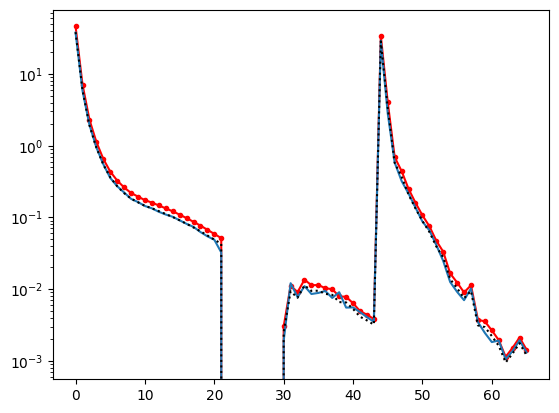

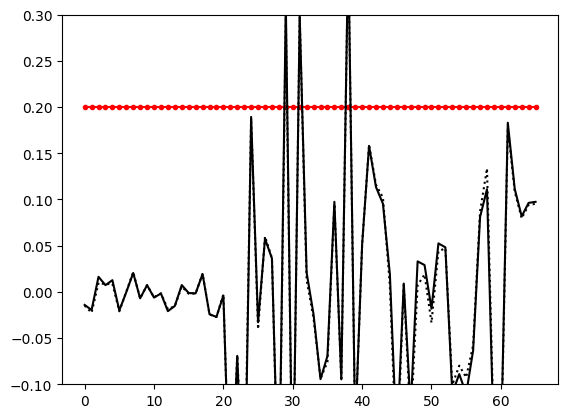

step: 124 0.08546058411579356
[[-2.7703732e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.1144144e-02  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -7.5275922e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.2398190e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0031875e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.1560566e-04]]
[-1.54393092e-02 -2.56858878e-02  5.55071933e-03  7.72796711e-03
  1.30610149e-02 -1.96885280e-02 -1.79558818e-04  2.06307545e-02
 -6.58682734e-03  7.42699951e-03 -6.10454287e-03 -1.38341065e-03
 -1.78556088e-02 -1.49305845e-02  7.08087906e-03 -1.30715617e-03
 -1.51089323e-03  1.93306357e-02 -2.40632165e-02 -2.70076916e-02
 -4.16618027e-03 -2.41600215e-01 -7.51714781e

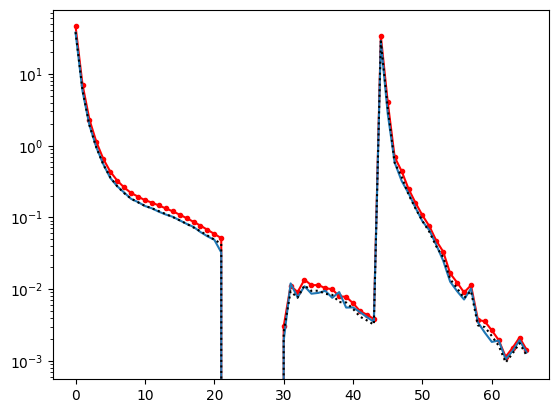

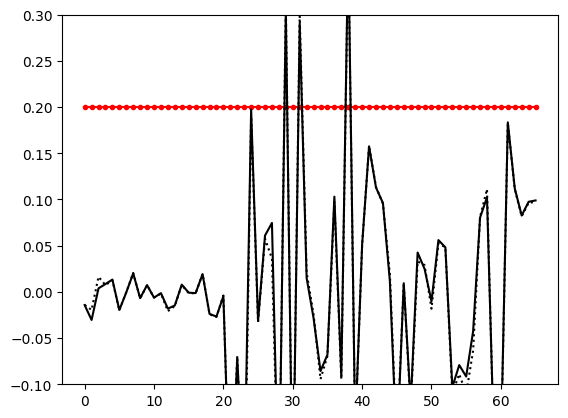

step: 127 0.08118755491000387
[[-1.2834661e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.0046200e-02  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -8.9719554e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.2474442e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.9940744e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.1603599e-04]]
[-0.01532619 -0.01795623 -0.00472782  0.0088791   0.01332668 -0.01898404
 -0.00046451  0.0198042  -0.00756157  0.00703645 -0.00647906 -0.00196972
 -0.02310253 -0.01506946  0.00624134 -0.00157691 -0.00174676  0.01876966
 -0.02448483 -0.02746734 -0.0055631  -0.2421859  -0.07074022 -0.23614569
  0.22172531 -0.01882642  0.06027649  0.05280092 -0.2520997   0.3031869
 -0.24

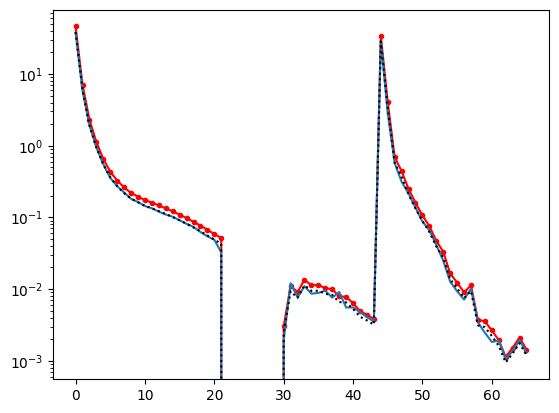

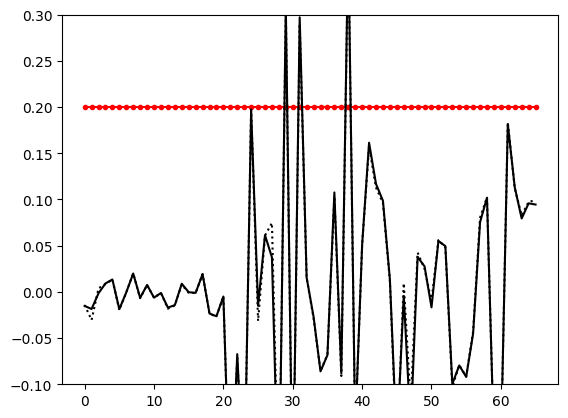

step: 130 0.07712817716450368
[[-3.1010742e-15  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.1252914e-15  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -5.8355108e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.2375854e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -5.9142945e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -5.7505821e-07]]
[-1.52115822e-02 -1.85239892e-02 -1.50408468e-03  9.11780261e-03
  1.34262964e-02 -1.87080912e-02 -5.51384699e-04  1.98875368e-02
 -6.45709597e-03  7.49176880e-03 -6.25221245e-03 -1.13658363e-03
 -1.70065444e-02 -1.43508529e-02  8.83395970e-03 -3.73227609e-04
 -1.03184069e-03  1.92472264e-02 -2.33398937e-02 -2.63326522e-02
 -5.02254022e-03 -2.40923837e-01 -6.73559904e

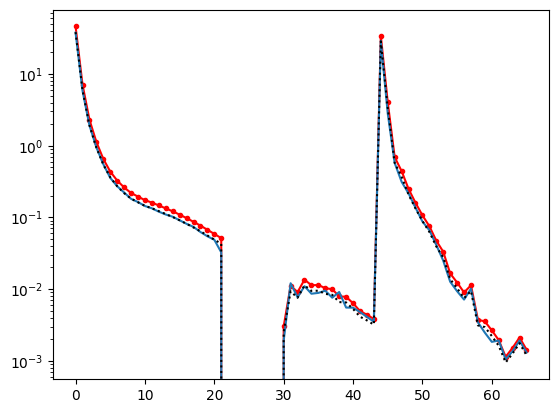

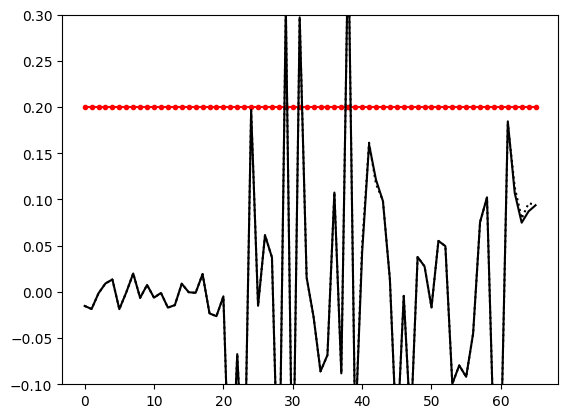

step: 133 0.07327176830627849
[[-1.9027552e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.5621765e-04  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.4209546e-06 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.4212831e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.2908610e-07  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -5.8341075e-06]]
[-0.03325091 -0.03650258 -0.01979447 -0.00936705  0.01125574 -0.01948991
 -0.00082702  0.01967421 -0.00656258  0.00743508 -0.00628512 -0.00115616
 -0.01700959 -0.01435286  0.00883558 -0.00037233 -0.00101664  0.01926032
 -0.02330089 -0.02618873 -0.00453762 -0.24067384 -0.08444011 -0.23806424
  0.21885313  0.00297593  0.04191191  0.01834831 -0.2567196   0.28443116
 -0.2

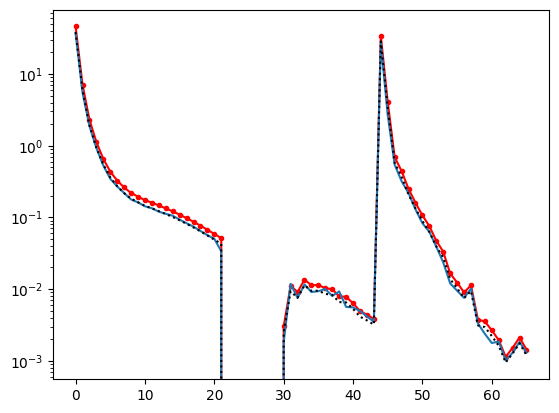

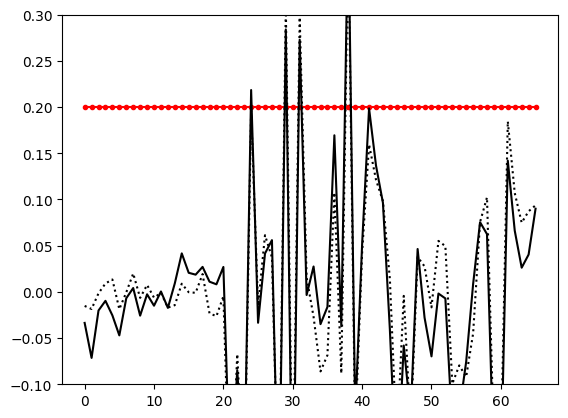

step: 136 0.06960817989096456
[[-8.1889883e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.2492365e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.8295944e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.5330012e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.2576379e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.1150988e-04]]
[-5.03931567e-02 -8.76360312e-02 -3.07148811e-03  7.53379334e-03
 -1.12335151e-02 -4.12803255e-02 -4.97199362e-03  1.08578913e-02
 -8.76409374e-03  1.26612056e-02 -1.04357107e-02  1.78527497e-02
 -2.39150148e-04  2.43481658e-02  5.97882494e-02  3.01832166e-02
  2.38955617e-02  2.82210913e-02  1.73308421e-02  1.38317505e-02
  2.30353177e-02 -2.13861063e-01 -6.88200220e

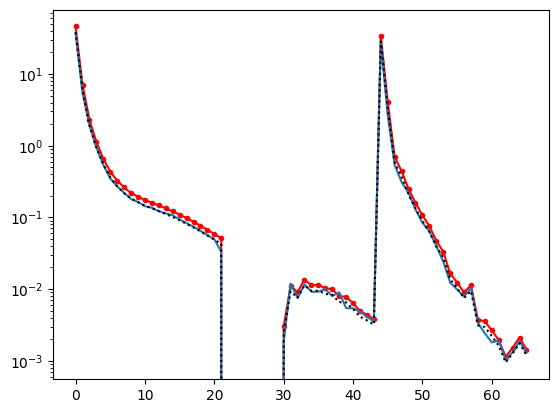

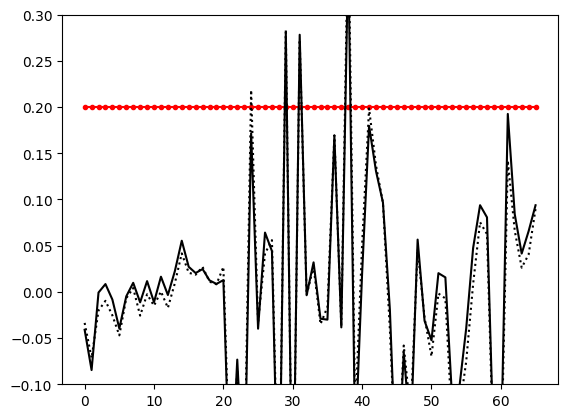

step: 139 0.06612777089641633
[[-3.8698468e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.8699706e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -4.5979410e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.1748831e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.1999491e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.0367018e-04]]
[-0.04293522 -0.08147734  0.00595724  0.01233111 -0.00619927 -0.03902132
 -0.00472583  0.01029324 -0.00906634  0.01229289 -0.01084725  0.01684787
 -0.00164345  0.02228837  0.05456288  0.02678078  0.02031824  0.0245913
  0.0119188   0.00796826  0.01083393 -0.22891831 -0.06939159 -0.23250803
  0.15236455 -0.04558031  0.06421521  0.0268819  -0.28269956  0.27137655
 -0.26

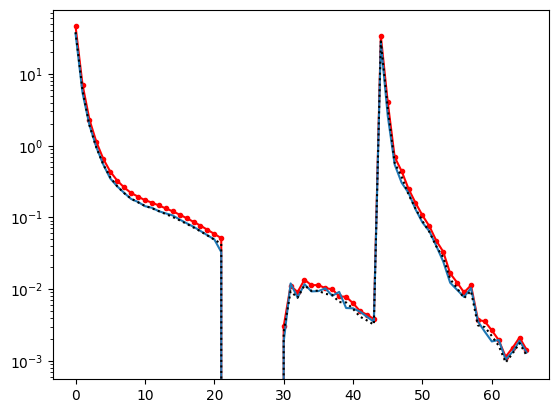

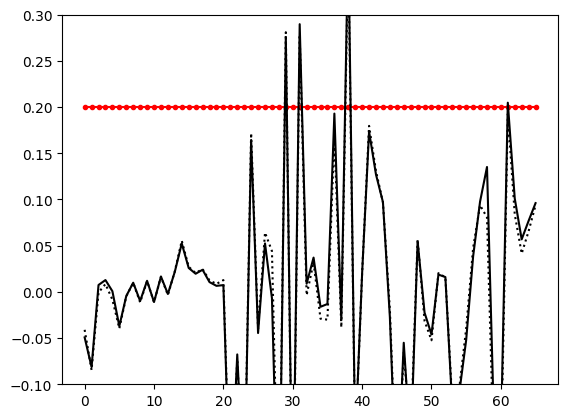

step: 142 0.06282138235159551
[[-1.8991472e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.6348597e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -7.0775865e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.5456832e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.2011758e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.9995065e-04]]
[-0.04975262 -0.08513013  0.01250865  0.01248673  0.00450838 -0.03612397
 -0.00441765  0.00989827 -0.00973949  0.01193634 -0.0110411   0.01645143
 -0.00245917  0.0216224   0.05162748  0.02555574  0.01942755  0.02371194
  0.01008505  0.00600116  0.00593713 -0.233773   -0.06708993 -0.21756269
  0.14821678 -0.04338244  0.04579245 -0.02238889 -0.2836921   0.27708155
 -0.2

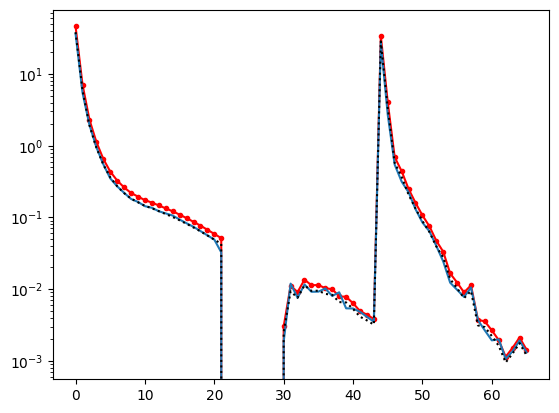

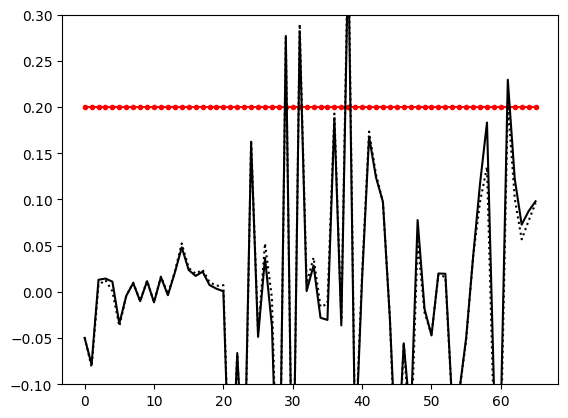

step: 145 0.059680313234015736
[[-8.2197637e-08  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.8931922e-10  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.4980168e-11 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.0905236e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -6.8202542e-07  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.8928654e-05]]
[-0.04981017 -0.07859225  0.01311145  0.01441151  0.01106034 -0.03436007
 -0.0042531   0.00954797 -0.01004981  0.01161727 -0.01130898  0.01599949
 -0.003612    0.0207978   0.04819356  0.02370843  0.01723664  0.02189302
  0.0073685   0.00339043  0.00074333 -0.23892857 -0.06619347 -0.21154879
  0.16151816 -0.04865963  0.03687816 -0.03722889 -0.28060415  0.2731098
 -0.2

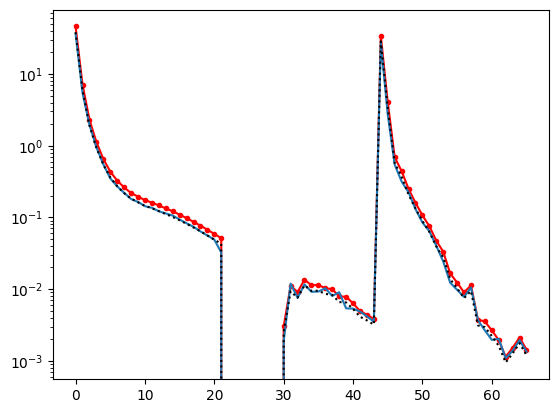

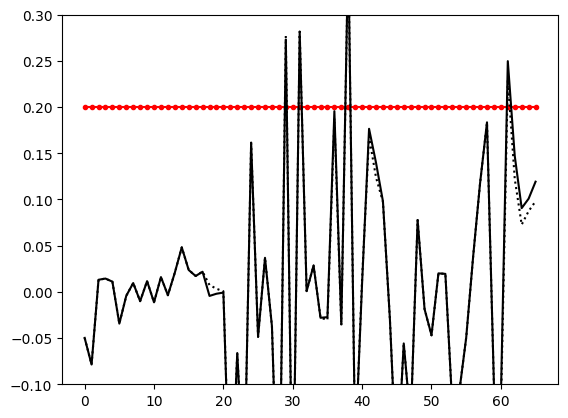

step: 148 0.056696297572314945
[[-6.1686788e-15  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.2788059e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.3728632e-13 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5464323e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -9.1444974e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -9.1628488e-07]]
[-0.04981017 -0.07859225  0.01311145  0.01441151  0.01106023 -0.03436032
 -0.00425321  0.00954791 -0.01004998  0.0116169  -0.01130939  0.01599893
 -0.00361304  0.02079525  0.04818811  0.02369328  0.01715356  0.02180208
 -0.00439476 -0.00209711 -0.00101323 -0.24453072 -0.06619347 -0.21154988
  0.16151832 -0.0486594   0.03688267 -0.03721948 -0.28060296  0.27308947
 -0.

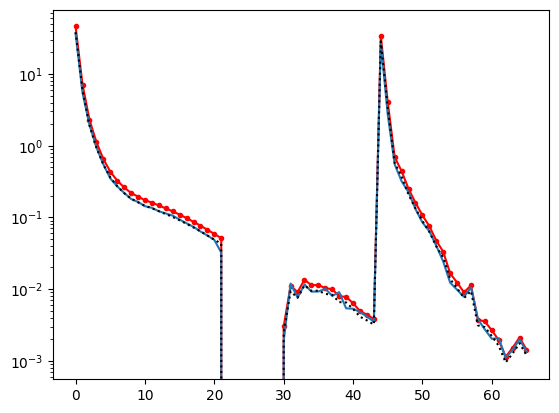

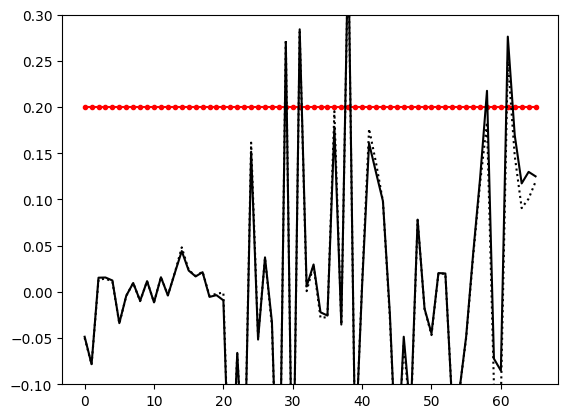

step: 151 0.0538614826936992
[[-1.1921201e-14  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.5660214e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.2357406e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.6263806e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0857854e-07  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -8.9856649e-06]]
[-0.04856965 -0.07825776  0.0153544   0.01556068  0.0123449  -0.03385198
 -0.00418474  0.00962857 -0.00965882  0.0116158  -0.01138631  0.01583553
 -0.00388273  0.02049347  0.04417495  0.02308166  0.01671939  0.02132802
 -0.00543242 -0.00350295 -0.00922716 -0.24575363 -0.06604443 -0.21234219
  0.15173697 -0.05161478  0.03735138 -0.03264796 -0.2792902   0.27034205
 -0.25

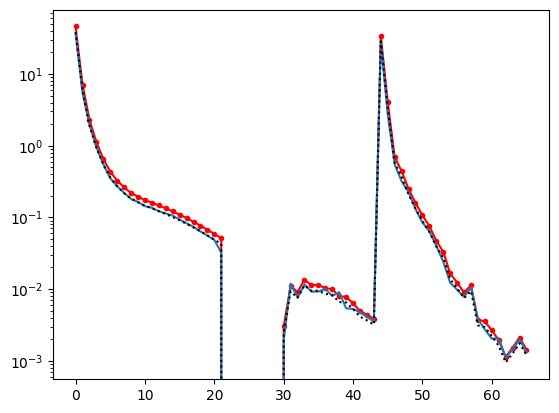

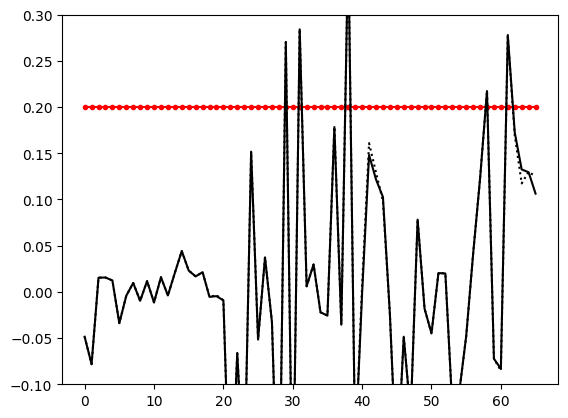

step: 154 0.051168408559014236
[[-2.3096043e-15  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.1646252e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -7.7129221e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.1203999e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -8.5020567e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -5.3824715e-06]]
[-0.04856965 -0.07825776  0.0153544   0.01556068  0.0123449  -0.03385206
 -0.00418474  0.00962864 -0.00965874  0.01161589 -0.0113861   0.01583575
 -0.00388255  0.02049387  0.0441765   0.02308403  0.01672507  0.02133833
 -0.00540855 -0.00458042 -0.00910545 -0.24536677 -0.06604443 -0.21234219
  0.15173721 -0.0516147   0.03735168 -0.03264752 -0.27928945  0.27034923
 -0.

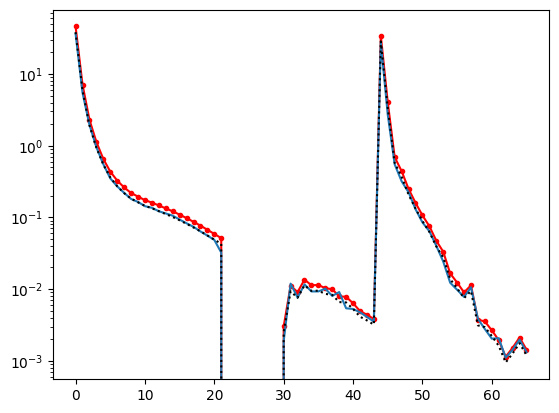

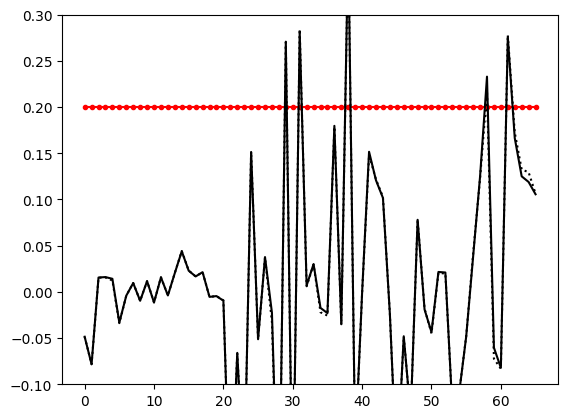

step: 157 0.04860998813106352
[[-8.3352748e-16  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.5386381e-15  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -6.5193199e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.8312124e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -5.7265503e-09  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -5.9541503e-06]]
[-4.8555236e-02 -7.8319229e-02  1.5544111e-02  1.6010510e-02
  1.4165068e-02 -3.3218078e-02 -4.1134199e-03  9.5384642e-03
 -9.6366983e-03  1.1579967e-02 -1.1455723e-02  1.5699381e-02
 -3.8559074e-03  2.0400532e-02  4.3943144e-02  2.2920465e-02
  1.6706843e-02  2.1343386e-02 -5.4447609e-03 -4.5369691e-03
 -9.5097702e-03 -2.4626189e-01 -6.6022769e-02 -2.1097288e-01
  1.

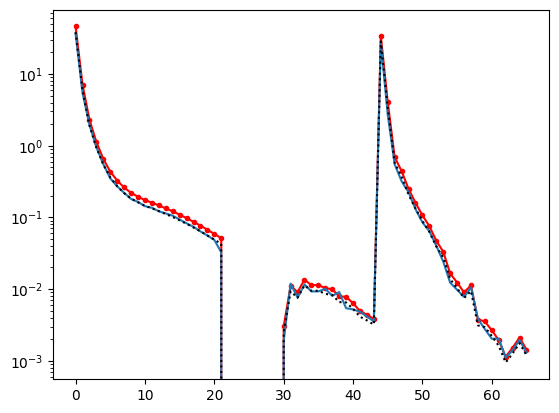

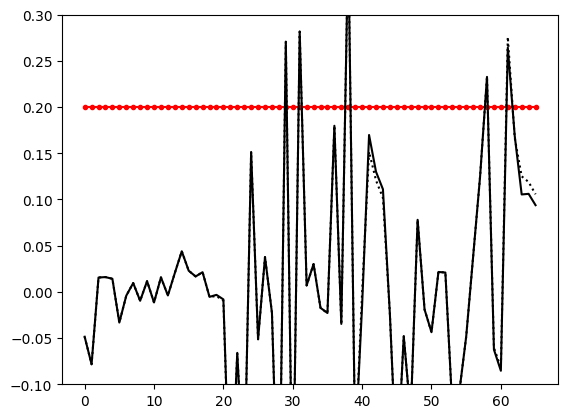

step: 160 0.046179488724510345
[[-1.7994114e-15  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.6238708e-15  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -6.6773681e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.9502124e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -4.2615465e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -5.1816772e-07]]
[-0.04855524 -0.07831923  0.01554411  0.01601045  0.01416485 -0.03321841
 -0.00411386  0.00953792 -0.00963809  0.01157767 -0.01145737  0.01569816
 -0.00385786  0.02039698  0.04393939  0.02290753  0.01669704  0.02130606
 -0.00540914 -0.00320346 -0.00811939 -0.23925227 -0.06602277 -0.21097302
  0.15142204 -0.05126607  0.03766779 -0.02261555 -0.27654484  0.27060345
 -0.

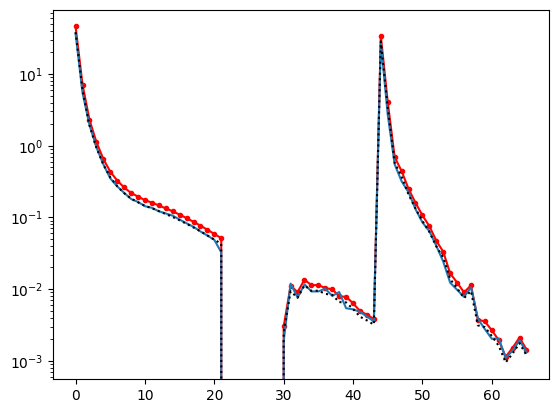

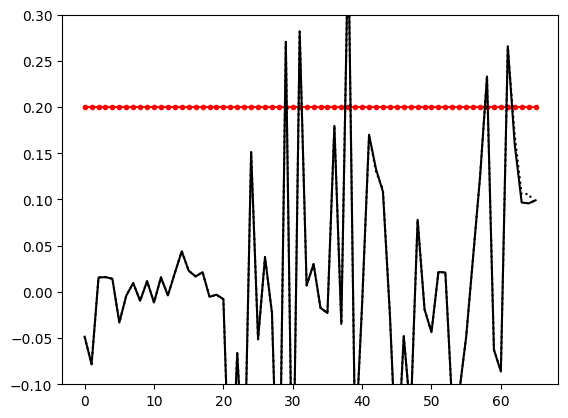

step: 163 0.043870514288284826
[[-5.9100308e-14  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.6508871e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.6631939e-12 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.8246435e-07
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0396873e-06  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.1940816e-06]]
[-0.04855524 -0.07831923  0.01554411  0.01601051  0.01416485 -0.03321816
 -0.00411353  0.00953826 -0.00963768  0.01157813 -0.01145696  0.01569871
 -0.00385719  0.02039812  0.04394123  0.02291048  0.0167051   0.02124637
 -0.0054238  -0.00309833 -0.00781121 -0.23890029 -0.06602277 -0.21097302
  0.15142228 -0.05126537  0.03766929 -0.02261245 -0.27653882  0.27067477
 -0.

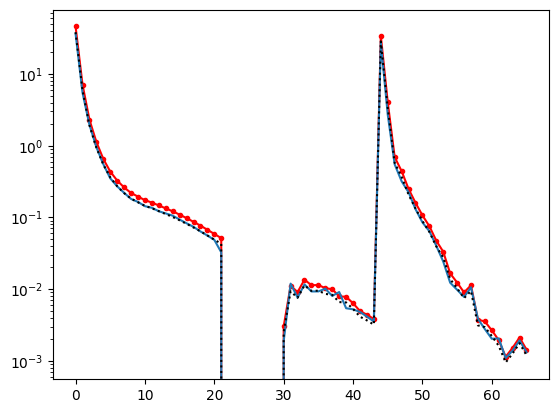

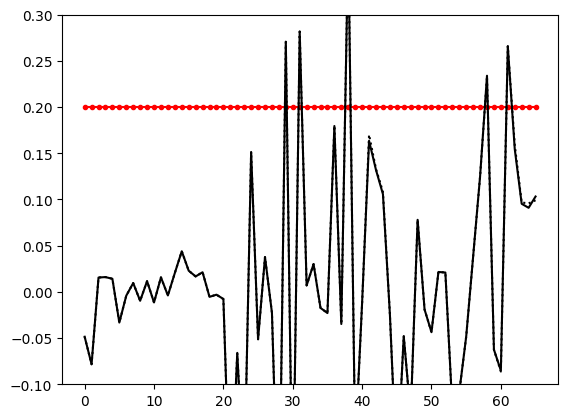

step: 166 0.04167698857387058
[[-1.6673051e-13  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.3915281e-13  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.3797680e-12 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.8946636e-07
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.1830100e-06  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.9251263e-06]]
[-0.04855524 -0.07831923  0.01554411  0.01601038  0.01416452 -0.03321849
 -0.00411397  0.00953737 -0.0096389   0.01157657 -0.01145912  0.01569827
 -0.00385859  0.02039678  0.04393048  0.02288674  0.01669494  0.0212309
 -0.00552241 -0.00332177 -0.00958611 -0.2366466  -0.06602277 -0.21097317
  0.15142062 -0.0512695   0.03766679 -0.02262253 -0.27655303  0.2703599
 -0.252

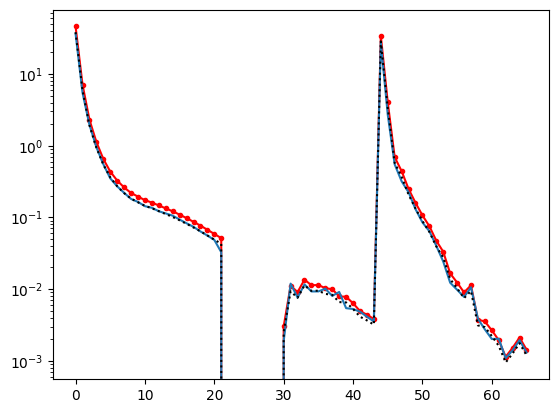

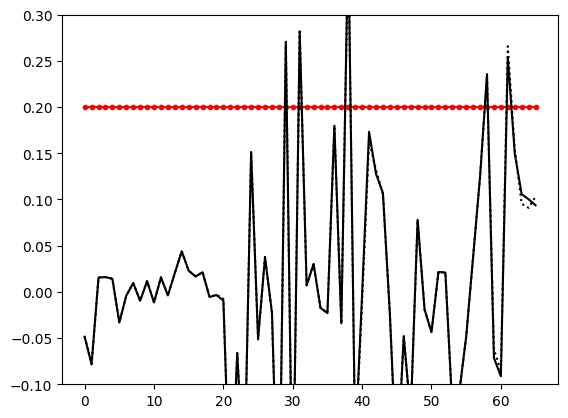

step: 169 0.03959313914517705
[[-5.4502745e-14  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.7697238e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.0414581e-13 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.6146795e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.3954724e-07  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -7.1444015e-07]]
[-0.04855524 -0.07831923  0.01554411  0.01601038  0.01416452 -0.03321832
 -0.00411386  0.00953757 -0.00963866  0.01157694 -0.0114586   0.01569882
 -0.0038581   0.02039765  0.04393144  0.02288952  0.01669961  0.02123874
 -0.00549436 -0.00341632 -0.00945078 -0.23635535 -0.06602277 -0.21097317
  0.15142125 -0.0512695   0.03766779 -0.02262053 -0.2765487   0.27040312
 -0.2

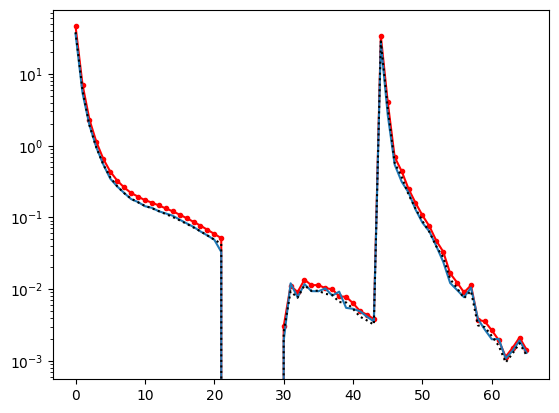

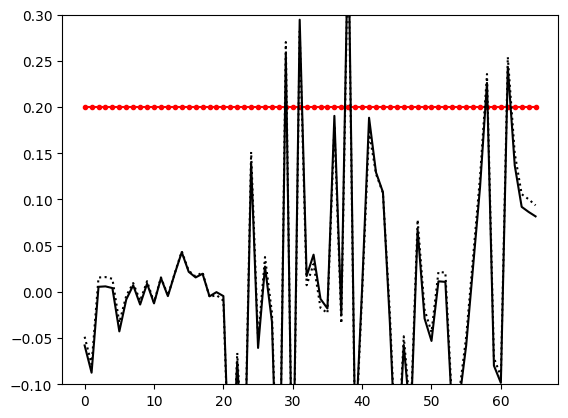

step: 172 0.0376134821879182
[[-5.3741667e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.8630767e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.5658542e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.2980605e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.3585551e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.4812040e-04]]
[-6.6831142e-02 -9.6023358e-02  1.4947017e-02  1.4725479e-02
 -5.3161150e-03 -5.1788773e-02 -1.7510327e-02  4.5562494e-03
 -1.4432351e-02  6.1912334e-04 -1.7333517e-02  9.9300342e-03
 -1.3937216e-02  1.6740888e-02  3.3171937e-02  1.8489216e-02
  1.0687727e-02  1.7465938e-02 -7.3136613e-03  6.1226627e-03
  2.3770428e-04 -2.2532065e-01 -8.3963193e-02 -2.2612929e-01
  1.2

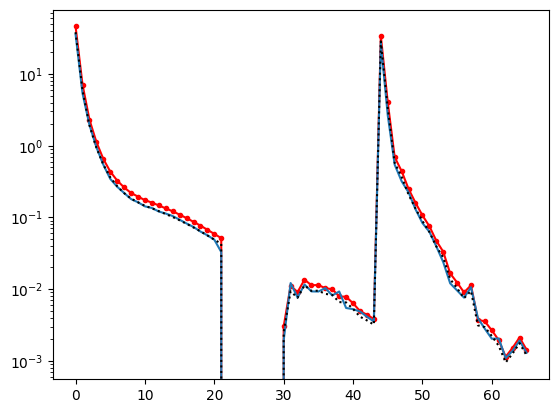

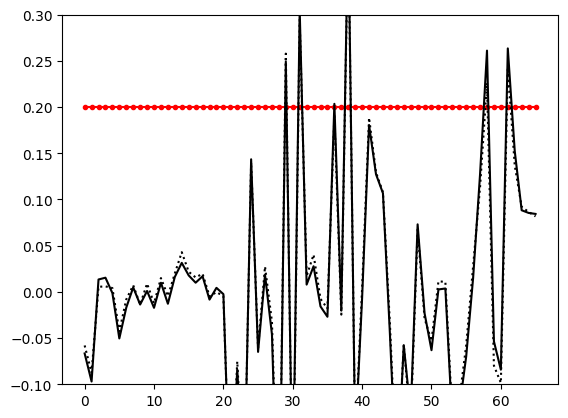

step: 175 0.035732808078522284
[[-1.1728349e-14  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -6.6545848e-15  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.8701828e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.1945357e-07
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -4.1430093e-07  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.6368684e-06]]
[-0.06665014 -0.09700381  0.01340709  0.01534846 -0.00129299 -0.05041003
 -0.01703147  0.00485147 -0.0136938   0.00098055 -0.01724539  0.00987564
 -0.01284559  0.01620756  0.03139684  0.01780563  0.00993819  0.01691703
 -0.00833549  0.00429982 -0.00244943 -0.23262613 -0.08392747 -0.22099683
  0.14349388 -0.06495202  0.01857896 -0.04594209 -0.29252747  0.24928482
 -0.

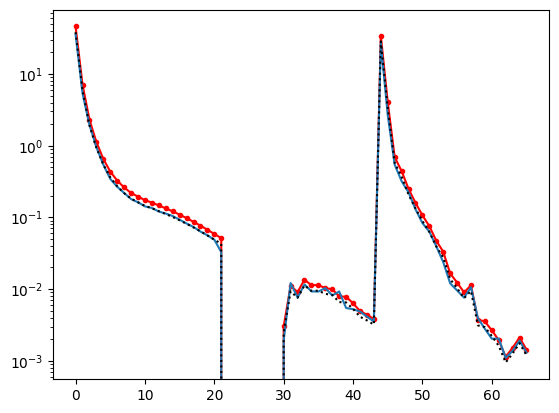

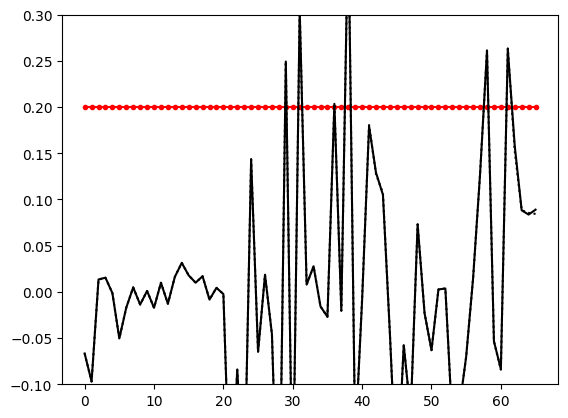

step: 178 0.03394616767459617
[[-9.5476546e-13  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.6518940e-13  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -7.3040055e-12 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.6997386e-07
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -4.4486278e-06  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.5539363e-05]]
[-0.06665014 -0.09700381  0.01340709  0.01534853 -0.00129288 -0.05040995
 -0.01703136  0.00485168 -0.01369348  0.00098101 -0.01724487  0.00987609
 -0.01284504  0.01620863  0.03139905  0.01780817  0.00994368  0.01691486
 -0.00837111  0.00432171 -0.00233099 -0.23415786 -0.08392747 -0.22099698
  0.14349395 -0.0649514   0.01858046 -0.04593921 -0.29252344  0.24933799
 -0.2

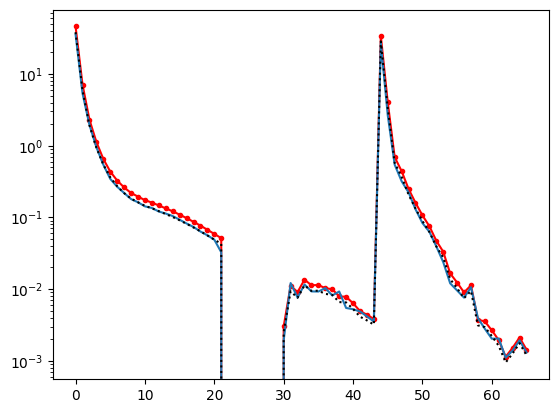

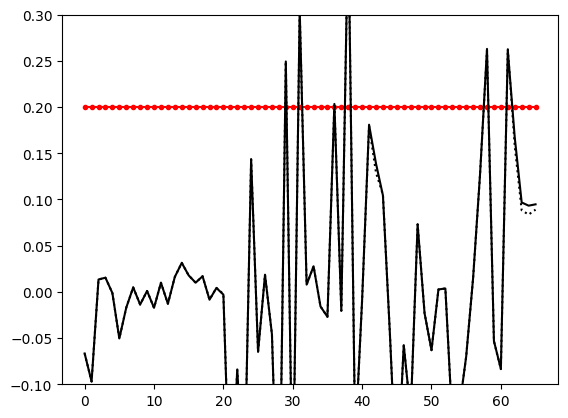

step: 181 0.03224885929086636
[[-4.3917578e-14  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.1775055e-13  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.3403076e-13 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.2130781e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -4.9004683e-07  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.7664841e-04]]
[-0.06665014 -0.09700381  0.01340709  0.01534853 -0.00129288 -0.05040995
 -0.01703136  0.00485174 -0.0136934   0.0009811  -0.01724477  0.0098762
 -0.01284492  0.01620883  0.03139934  0.01780817  0.00994011  0.01685094
 -0.00848008  0.00360017 -0.00306001 -0.24184638 -0.08392747 -0.22099698
  0.14349411 -0.06495124  0.01858076 -0.04593843 -0.2925218   0.2493584
 -0.234

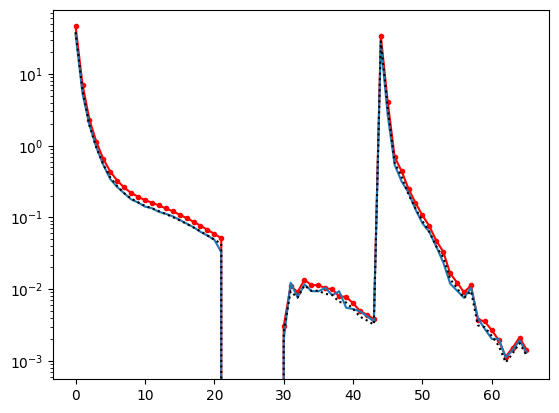

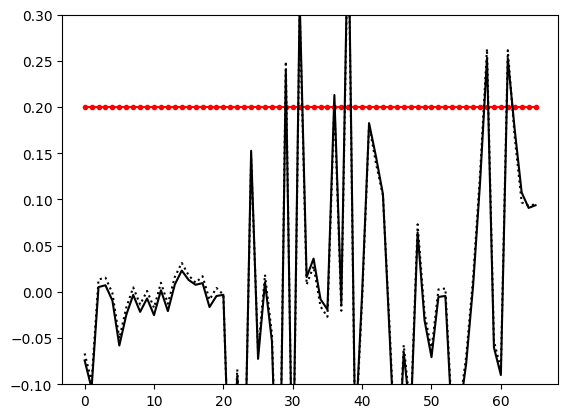

step: 184 0.030636416326323038
[[-3.8230196e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -6.4373557e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.2335939e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.0518239e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.5554911e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.9591480e-04]]
[-0.07413918 -0.10265756  0.00540393  0.00744868 -0.00875284 -0.05754271
 -0.02472993 -0.00301152 -0.02114083 -0.00684453 -0.02500649  0.00187517
 -0.02048199  0.0079252   0.02297952  0.01273657  0.00750427  0.0093972
 -0.01658412 -0.00486348 -0.00406396 -0.23816013 -0.09140556 -0.22794141
  0.15290737 -0.07085297  0.01178062 -0.04856136 -0.2981189   0.24055079
 -0.2

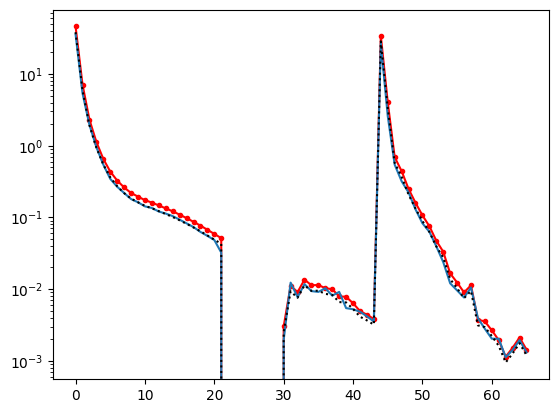

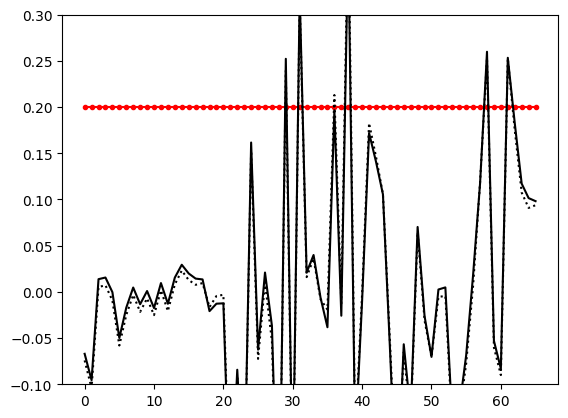

step: 187 0.029104595510006884
[[-2.7628706e-09  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.7078137e-11  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -5.0149255e-12 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.1415146e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.0049769e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.3085212e-04]]
[-6.70282543e-02 -9.55697149e-02  1.37531999e-02  1.55327274e-02
 -2.79789761e-04 -4.99122925e-02 -1.71147268e-02  4.71183006e-03
 -1.33596379e-02  9.20554332e-04 -1.75059699e-02  9.53248609e-03
 -1.28810667e-02  1.54438252e-02  2.93545853e-02  1.99252293e-02
  1.43634239e-02  1.34186819e-02 -2.07624584e-02 -1.28774466e-02
 -1.29072741e-02 -2.47396141e-01 -8.42657909

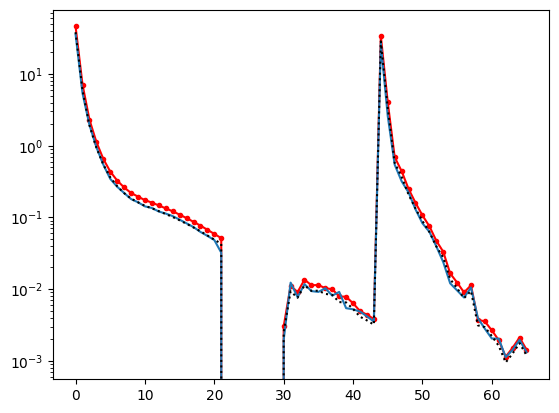

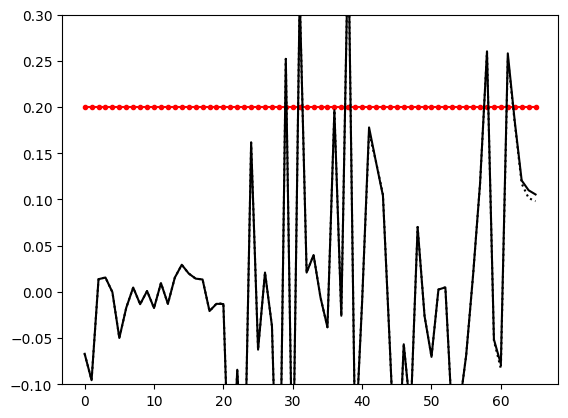

step: 190 0.027649365734506538
[[-2.1506395e-14  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.4943728e-13  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.6489754e-12 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.7778939e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.8603276e-07  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.3718985e-06]]
[-6.70282543e-02 -9.55697149e-02  1.37531999e-02  1.55327274e-02
 -2.79789761e-04 -4.99122925e-02 -1.71147268e-02  4.71196696e-03
 -1.33594749e-02  9.20738094e-04 -1.75057631e-02  9.53270867e-03
 -1.28808841e-02  1.54440925e-02  2.93533318e-02  1.99200716e-02
  1.43552721e-02  1.34110525e-02 -2.07544249e-02 -1.29075889e-02
 -1.31127825e-02 -2.47571826e-01 -8.42657909

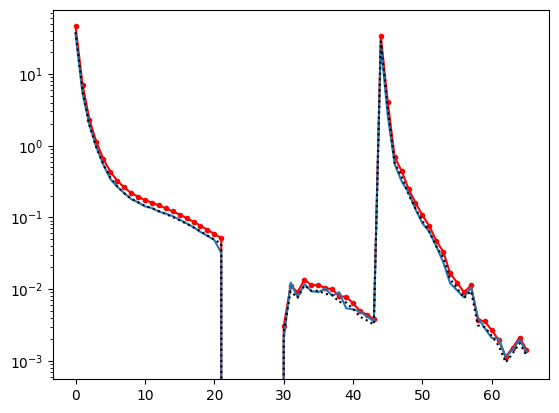

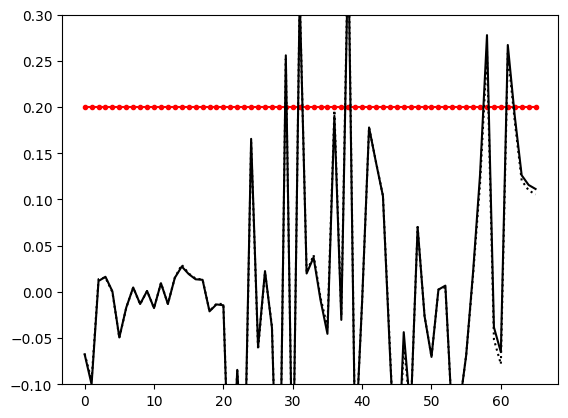

step: 193 0.02626689744778121
[[-1.09476864e-01  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -7.48479785e-03  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -7.19708973e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.12029329e-05
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -3.27097077e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -3.35777324e-04]]
[-0.06744444 -0.10030288  0.00756725  0.01654495  0.00061015 -0.04925292
 -0.01692794  0.0047171  -0.01318713  0.00100673 -0.01756489  0.00937976
 -0.01300762  0.0151401   0.02683332  0.01913981  0.01338847  0.01303638
 -0.02099681 -0.0135962  -0.01480183 -0.25038174 -0.08474616 -0.2197013
  0.17326458 -0.05748801  0.02451398 -0.032

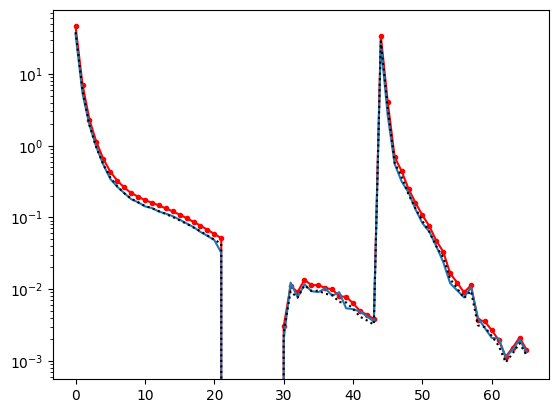

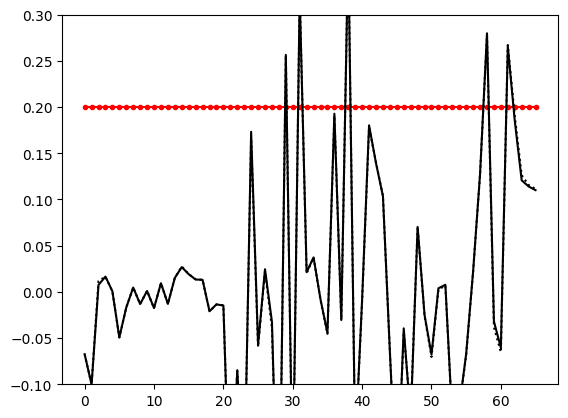

step: 196 0.024953552575392147
[[-2.2708369e-14  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.3006258e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.2977342e-13 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.1643014e-07
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0830506e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.0409135e-04]]
[-0.06744444 -0.10030288  0.00756725  0.01654495  0.00061015 -0.04925292
 -0.01692794  0.00471717 -0.01318704  0.00100691 -0.01756469  0.00937987
 -0.01300744  0.0151405   0.02683384  0.01914153  0.01339158  0.01304484
 -0.02093115 -0.01351436 -0.01477237 -0.251034   -0.08474616 -0.2197013
  0.17326458 -0.05748786  0.02451428 -0.03248486 -0.30049813  0.25652543
 -0.2

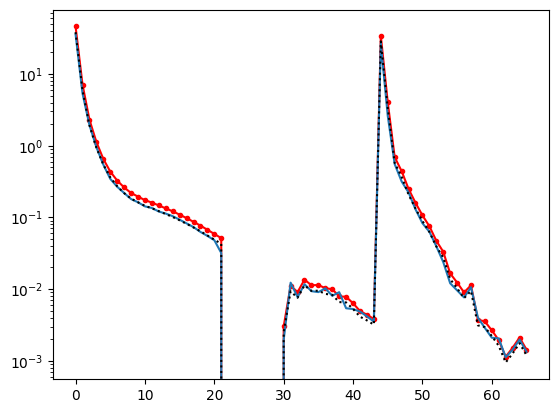

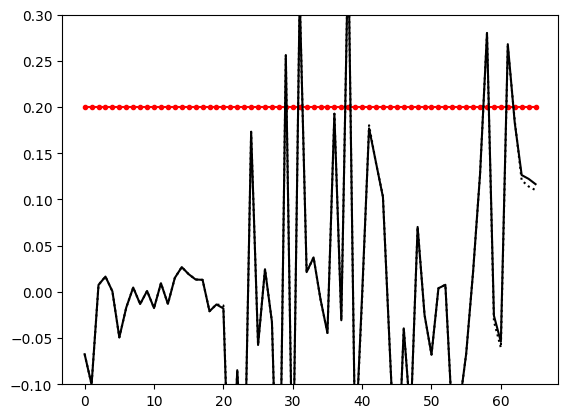

step: 199 0.02370587494662254
[[-5.5205319e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.6837638e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -4.0573621e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.7672906e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.4553370e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.3385519e-04]]
[-0.06685003 -0.1056349   0.00159593  0.01698767  0.00050124 -0.04909448
 -0.01673874  0.00517871 -0.01191079  0.00230763 -0.0166581   0.01047219
 -0.0071592   0.01568756  0.02634128  0.01893686  0.01259688  0.01266006
 -0.0206259  -0.01388791 -0.01866363 -0.25918508 -0.0855555  -0.22062407
  0.166311   -0.06307895  0.01843968 -0.03823021 -0.3035465   0.26379234
 -0.2

In [22]:
from datetime import datetime, timedelta
from jax.scipy.optimize import minimize

from multiprocessing.pool import ThreadPool as Pool 
pool = Pool() #jax pmap? check re-compilation times?
pmap = pool.map

#method = 'L-BFGS-B'
method = "l-bfgs-experimental-do-not-rely-on-this"
θ_rtol = 1e-5
z_rtol = 1e-5

θ_tol = 1e-5
z_tol = 1e-6

history = []
α=0.7
beta = 0.25

θ̃ = start_point
θ = start_point# if result.θ is not None else θ_start)
θL = start_point
Nθ = len(ravel_θ(θ̃))
time = timedelta(0)
for i in range(1, maxsteps+1):
        print("step:",i,α)
        t0 = datetime.now()

        if i > 1:
            xs = [x_data] + [prob.sample_x_z(_rng, θ)[0] for _rng in _split_rng(rng,nsims)]
            θ_tol = np.sqrt(-np.diag(H̃_inv_post)) * θ_rtol

        if i > 2:
            Δθ̃ = ravel_θ(history[-1]["θ̃"])- ravel_θ(history[-2]["θ̃"])
          #  if np.sqrt(-np.inner(Δθ̃, np.inner(np.linalg.pinv(history[-1]["H̃_inv_post"]), Δθ̃))) < θ_rtol:
           #     break

        # MUSE gradient
        def get_MAPs(x_z):
            x, ẑ_prev = x_z
            result = prob.z_MAP_and_score(x, ẑ_prev, θ, method=method, z_tol=z_tol, θ_tol=θ_tol)
            
            return result

        MAPs = list(pmap(get_MAPs, zip(xs, ẑs)))

        ẑs = [MAP.z for MAP in MAPs]
   #     if save_MAP_history:
    #        MAP_history_dat, *MAP_history_sims = [MAP.history for MAP in MAPs]
        s_MAP_dat, *s_MAP_sims = [MAP.s for MAP in MAPs]
        s̃_MAP_dat, *s̃_MAP_sims = [MAP.s̃ for MAP in MAPs]
        s̃_MUSE = unravel_θ(ravel_θ(s̃_MAP_dat) - np.nanmean(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0))
        s̃_prior, H̃_prior = gradθ_hessθ_logPrior(θ̃, transformed_θ=True)
        s̃_post = unravel_θ(ravel_θ(s̃_MUSE) + ravel_θ(s̃_prior))

        # print(s̃_MAP_sims)
        # H̃_inv_like_sims = np.diag(-1 / np.nanvar(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0))
        epsilon = 1e-8  # A small value to avoid division by zero
        variance = np.nanvar(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0)
        variance += epsilon  # Add epsilon to the variance to prevent zero values
        H̃_inv_like_sims = np.diag(-1 / variance)
        print(H̃_inv_like_sims)
        
       # try:
        # H̃_inv_post = np.linalg.pinv(np.linalg.pinv(H̃_inv_like_sims) + ravel_θ(H̃_prior).reshape(Nθ,Nθ))
        H̃_inv_post = np.linalg.pinv(np.linalg.pinv(H̃_inv_like_sims) + ravel_θ(H̃_prior).reshape(Nθ,Nθ))
        #except:
        #    print("error on Hessian inversion calc, prior ignored and trying again...")
       # H̃_inv_post = H̃_inv_like_sims
        t = datetime.now() - t0
        time += t

        history.append({
            "t":t, "θ̃":θ̃, "θ":θ,
            "s_MAP_dat": s_MAP_dat, "s_MAP_sims": s_MAP_sims,
            "s̃_MAP_dat": s̃_MAP_dat, "s̃_MAP_sims": s̃_MAP_sims, 
            "s̃_MUSE": s̃_MUSE,
            "s̃_prior": s̃_prior, "s̃_post": s̃_post, 
            "H̃_inv_post": H̃_inv_post, "H̃_prior": H̃_prior, 
            "H̃_inv_like_sims": H̃_inv_like_sims,
            "θ_tol": θ_tol,
        #    "MAP_history_dat": MAP_history_dat, 
         #   "MAP_history_sims": MAP_history_sims,
        })
        θ̃update = np.clip((np.inner(H̃_inv_post, ravel_θ(s̃_post))),-jnp.abs(ravel_θ(θ̃)*beta),jnp.abs(ravel_θ(θ̃)*beta))
        θ̃ = unravel_θ((ravel_θ(θ̃) - α * θ̃update))
        θ = θ̃
        print(((θ-tf_cut_flat)/tf_cut_flat))
        #print(θ)
        if i%3==0:
            plt.semilogy(start_point,"r.-")
            plt.plot(θ)
            plt.plot(tf_cut_flat,"k:")
            plt.show()
            
            
            plt.plot((start_point-tf_cut_flat)/tf_cut_flat,"r.-")
            plt.plot((θ-tf_cut_flat)/tf_cut_flat,"k")
            plt.plot((θL-tf_cut_flat)/tf_cut_flat,"k:")
    
            plt.ylim([-.1,.3])
            plt.show()
            
            θL = θ
            #LR decay
            α *= 0.95

In [23]:
#as you can see, convergence properties are wonky, takes a bit of time to start moving... 
#Should converge if you have the patients to let it run a couple of hours


In [24]:
#Now lets try to calculate the covariance! :D

In [25]:
s_MAP_sims = history[-1]["s_MAP_sims"]
_, *z_MAP_sims = ẑs

In [26]:
def z_MAP_guess_from_truth(x, z, θ):
        return unravel_z(0 * ravel_z(z))
    
nsims = 4
    
def get_J(
        result = None,
        θ = None,
        θ_tol = None,
        z_tol = None,
        method = None,
        rng = None,
        nsims = 10, 
        pmap = map,
        progress = False, 
        skip_errors = False,
    ):

        nsims_remaining = nsims 

        if nsims_remaining > 0:
            print(nsims_remaining)
            t0 = datetime.now()

            def get_s_MAP(rng):
                    (x, z) = prob.sample_x_z(rng, θ)
                    z_MAP_guess = prob.z_MAP_guess_from_truth(x, z, θ)
                    return prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol).s
                

            rngs = _split_rng(rng, nsims_remaining)
            s_MAP_sims.extend(s for s in pmap(get_s_MAP, rngs) if s is not None)

#            time += datetime.now() - t0

        J = np.atleast_2d(np.cov(np.stack(list(map(ravel_θ, s_MAP_sims))), rowvar=False))
        return J



In [27]:
J = get_J(rng=rng,θ =θ,method=method, θ_tol=θ_tol, z_tol=z_tol)

10


In [28]:
Hs = []

In [29]:
def pjacobian(f, x, step, pmap=map, pbar=None):
    print(step,x)
    step = step + np.array(0 * x) # make array if scalar

    def column(i):
    
        def v(ε):
            ε_vec = np.array(0 * x)
            ε_vec[i] = ε
            v = f(x + ε_vec)
            if pbar: pbar.update()
            return v

        return (v(step[i]) - v(-step[i])) / (2 * step[i])

    return np.array(list(pmap(column, range(len(x)))))

In [30]:
#This takes a while, roughly an hour or two... Can probably parallelize it across GPUs if you want.

from tqdm import tqdm
from jax.scipy.sparse.linalg import cg

step = None
skip_errors = False
def _get_H_i_old(rng, z_MAP_guess_fid, *, θ, method=None, θ_tol=None, z_tol=None, step=None, skip_errors=False):
    
    # for each sim, do one fit at fiducial which we'll
    # reuse as a starting point when fudging θ by +/-ϵ
    θfid = θ
    (x, z) = prob.sample_x_z(rng, θfid)
    if z_MAP_guess_fid is None:
        z_MAP_guess = _MAP_guess_from_truth(x, z, θfid)
        z_MAP_guess_fid = z_MAP_and_score(x, z_MAP_guess, θfid, method=method, θ_tol=θ_tol, z_tol=z_tol).z

    def get_s_MAP(θvec):
        θ = unravel_θ(θvec)
        (x, _) = prob.sample_x_z(copy(rng), θ)
        return ravel_θ(prob.z_MAP_and_score(x, z_MAP_guess_fid, θfid, method=method, θ_tol=θ_tol, z_tol=z_tol).s)

    return pjacobian(get_s_MAP, ravel_θ(θfid), step)


def _get_H_i(rng, z_MAP, *, θ, implicit_diff_cgtol=1e-3, method=None, θ_tol=None, z_tol=None, step=None, skip_errors=False):

        #implicit implementation..
        cg_kwargs = dict(tol=implicit_diff_cgtol)

        (x, z) = prob.sample_x_z(rng, θ)
        if z_MAP is None:
            z_MAP_guess = z_MAP_guess_from_truth(x, z, θ)
            z_MAP = prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol).z

        θ_vec, z_MAP_vec = ravel_θ(θ), ravel_z(z_MAP)
        #unravel_θ, unravel_z = unravel_θ, unravel_z

        # non-implicit-diff term
        H1 = jacfwd(
            lambda θ1: grad(
                lambda θ2: prob.logLike(prob.sample_x_z(rng, unravel_θ(θ1))[0], z_MAP, unravel_θ(θ2))
            )(θ_vec)
        )(θ_vec)

        # term involving dzMAP/dθ via implicit-diff (w/ conjugate-gradient linear solve)
        dFdθ = jacfwd(
            lambda θ: grad(
                lambda z: prob.logLike(x, unravel_z(z), unravel_θ(θ))
            )(z_MAP_vec)
        )(θ_vec)
        dFdθ1 = jacfwd(
            lambda θ1: grad(
                lambda z: prob.logLike(prob.sample_x_z(rng, unravel_θ(θ1))[0], unravel_z(z), θ)
            )(z_MAP_vec)
        )(θ_vec)
        inv_dFdz_dFdθ1 = vmap(
            lambda vec: cg(
                lambda vec: jvp(lambda z: grad(lambda z: prob.logLike(x, unravel_z(z), θ))(z), (z_MAP_vec,), (vec,))[1], 
                vec, 
                **cg_kwargs
            )[0], 
            in_axes=1, out_axes=1
        )(dFdθ1)
        H2 = -dFdθ.T @ inv_dFdz_dFdθ1
        return H1 + H2

Hs = []

nsims_remaining = nsims  #- len(result.Hs)

z_MAP_sims = z_MAP_sims[:4]

if nsims_remaining > 0:

    # default to finite difference step size of 0.1σ with σ roughly
    # estimated from s_MAP_sims sims, if we have them
    if step is None:
        if len(s_MAP_sims) > 0:
            step = 0.1 / np.std(np.stack(list(map(ravel_θ, s_MAP_sims))), axis=0)
        else:
            step = 1e-5
    
    Nθ = len(ravel_θ(θ))
    pbar = partial(tqdm, total=nsims_remaining, desc="get_H", disable=(True))

    t0 = datetime.now()
    rngs = _split_rng(rng, nsims)[-nsims_remaining:]
    z_MAP_sims = (z_MAP_sims + [None]*(max(0, nsims - len(z_MAP_sims))))[-nsims_remaining:]
    _get_H_ii = partial(_get_H_i, θ=θ, method=method, θ_tol=θ_tol, z_tol=z_tol, step=step, skip_errors=skip_errors)
    Hs.extend(H for H in pbar(map(lambda args: _get_H_ii(*args), zip(rngs, z_MAP_sims)) )if H is not None)
   # result.time += datetime.now() - t0

avg = np.mean#np.median if use_median else np.mean
H = avg(np.array(Hs), axis=0)

In [31]:
Hs[0]

Array([[ 9.1308594e-02,  6.0302734e-01,  8.1066895e-01, ...,
         4.9284667e-02, -1.7618656e-02,  1.1092037e-02],
       [ 2.0605469e-01,  6.6562500e+01,  6.9500000e+01, ...,
         3.7825775e-01, -2.9750061e-01, -2.9462814e-02],
       [ 5.4214478e-01,  7.5828125e+01,  1.3201250e+03, ...,
        -3.9422607e-01, -4.9903870e-02,  9.4782829e-02],
       ...,
       [ 4.0482581e-03,  1.6667843e-01,  5.2033997e-01, ...,
         6.6764375e+04,  1.2123195e+04,  4.8880371e+02],
       [-2.6760772e-02, -2.3326874e-02,  1.7967606e-01, ...,
         1.2505441e+04,  1.9639492e+04,  2.3473760e+03],
       [-7.0004463e-03, -3.3512533e-02, -1.0108948e-04, ...,
         6.0171484e+02,  2.3482988e+03,  2.4708047e+03]], dtype=float32)

In [29]:
import scipy as sp

Nθ = len(ravel(θ))

H_prior = -ravel(prob.gradθ_hessθ_logPrior(θ, transformed_θ=False)[1]).reshape(Nθ,Nθ)
Σ_inv = H.T @ np.linalg.pinv(J) @ H + H_prior
Σ = np.linalg.pinv(Σ_inv)
try:
    if θ is not None:
        if Nθ == 1:
            dist = sp.stats.norm(ravel(θ), np.sqrt(Σ[0,0]))
        else:
            dist = sp.stats.multivariate_normal(ravel(θ), Σ)
except:
    print("likely error in covariance... proceed with caution!")

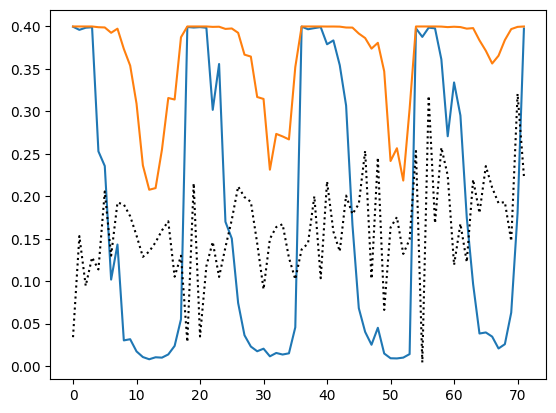

In [30]:
plt.plot(1/np.sqrt(np.diag(Σ_inv))/tf_cut_flat)
plt.plot(np.sqrt(np.diag(Σ))/tf_cut_flat)

plt.plot(abs((start_point-θ)/tf_cut_flat),"k:")

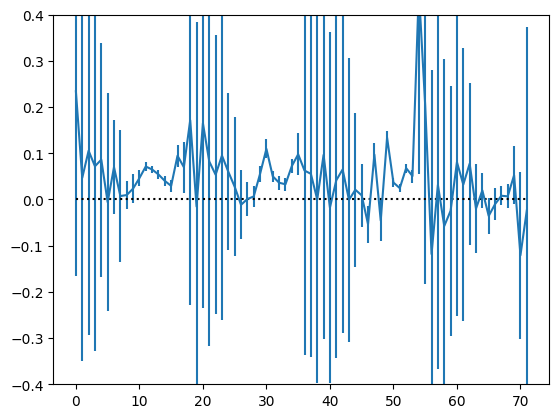

In [33]:
#need to run optimization for longer, since thsoe smaller scale modes in each mu-bin are not converged...
plt.errorbar(np.arange(len(tf_cut_flat)),(θ-tf_cut_flat)/tf_cut_flat,yerr=1/np.sqrt(np.diag(Σ_inv))/tf_cut_flat)
plt.plot(np.arange(len(tf_cut_flat)),np.arange(len(tf_cut_flat))*0.0,"k:")
plt.ylim(-0.4,0.4)
plt.show()

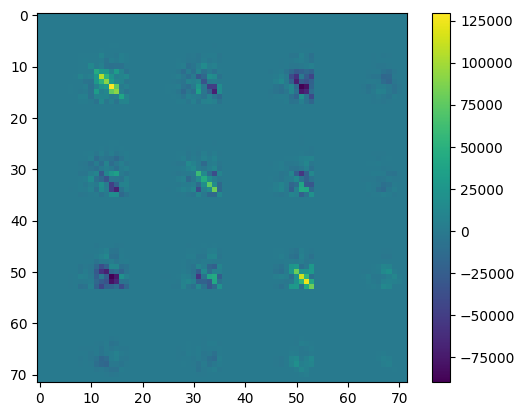

In [34]:
imshow(Σ_inv)
colorbar()